1. To predict 3 months of item-level sales data at different store locations.

## 1. Setup and Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import matplotlib.cm as cm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_raw = pd.read_csv("/your_train_dataset.csv", parse_dates=['date'])
test_raw = pd.read_csv("/your_test_dataset.csv", parse_dates=['date'])
train = train_raw.copy()

In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## 2. Exploratory Data Analysis (EDA)

### 2.1 Basic Info & Summary
Check data types, date range, missing values, and unique counts.

In [ ]:
print(train.shape)
print(train.columns)
print(train['sales'].describe())
train['date'] = pd.to_datetime(train['date'])

(913000, 4)
Index(['date', 'store', 'item', 'sales'], dtype='object')
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64


In [ ]:
print(train.info())
print("-----------")
print(train.describe())
print("-----------")
print(train['date'].min(), train['date'].max())
print("-----------")
print(f"Stores: {train['store'].nunique()}, Items: {train['item'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
-----------
                                date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:00      10.000000    

In [ ]:
train.isna().sum()

,0
date,0
store,0
item,0
sales,0


### 2.2 Sales Distribution & Outliers

#### Histogram + KDE Curve

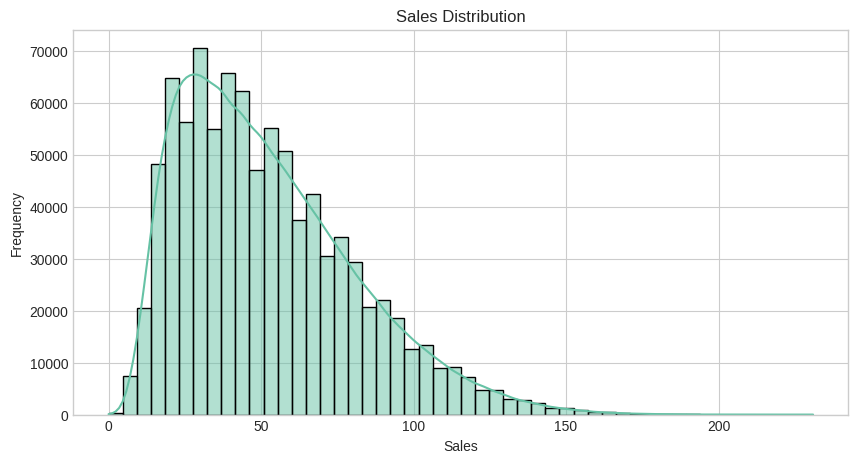

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(train['sales'], bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

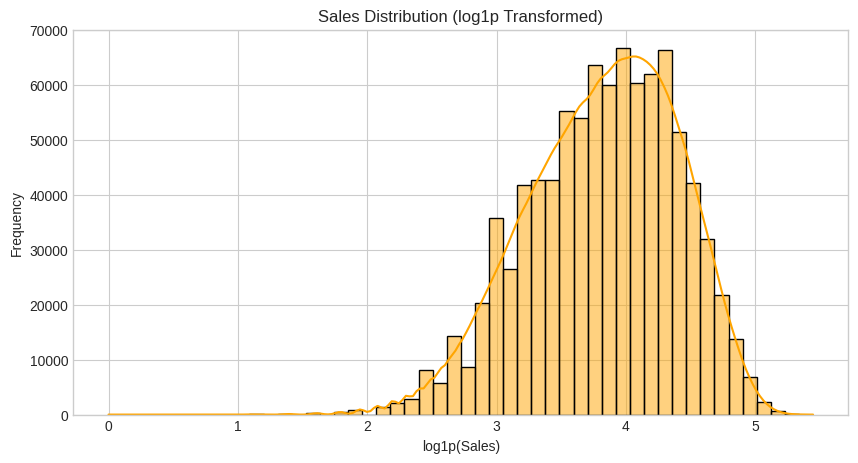

In [ ]:
# สร้างคอลัมน์ log
train['log_sales'] = np.log1p(train['sales'])  # log1p ปลอดภัยกว่า log(1 + x)

# Plot log-transformed
plt.figure(figsize=(10, 5))
sns.histplot(train['log_sales'], bins=50, kde=True, color='orange')
plt.title("Sales Distribution (log1p Transformed)")
plt.xlabel("log1p(Sales)")
plt.ylabel("Frequency")
plt.show()

#### Boxplot

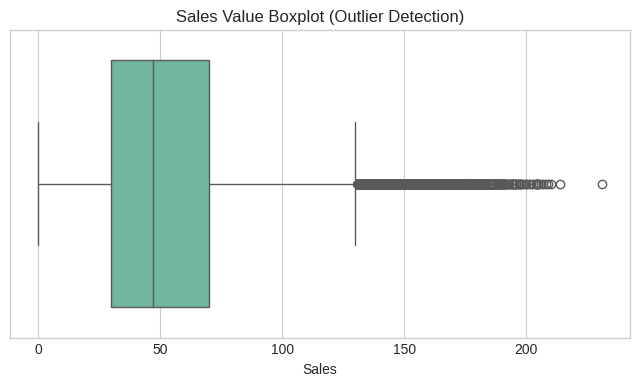

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=train['sales'])
plt.title("Sales Value Boxplot (Outlier Detection)")
plt.xlabel("Sales")
plt.show()

In [ ]:
Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['sales'] < lower_bound) | (train['sales'] > upper_bound)]
print(f"Number of outliers: {len(outliers)} ({len(outliers) / len(train) * 100:.2f}%)")


Number of outliers: 11967 (1.31%)


### 2.3 Weekly Sales Pattern by Store

#### Heatmap (avg sales by day/store)

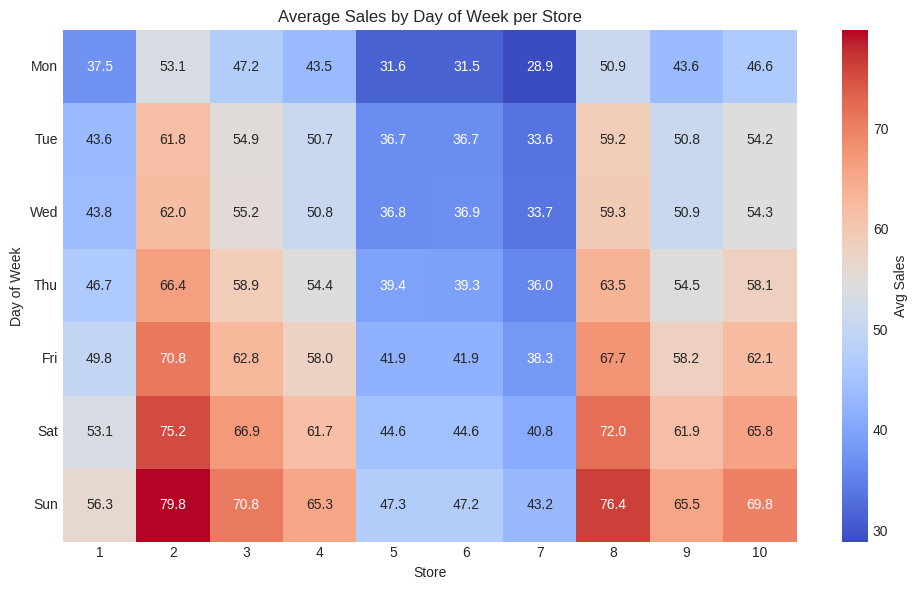

In [ ]:
train['dayofweek'] = train['date'].dt.dayofweek
dow_store_sales = train.groupby(['dayofweek', 'store'])['sales'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(dow_store_sales, cmap="coolwarm", annot=True, fmt=".1f", cbar_kws={'label': 'Avg Sales'})
plt.title('Average Sales by Day of Week per Store')
plt.xlabel('Store')
plt.ylabel('Day of Week')
plt.yticks(ticks=np.arange(7) + 0.5, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()

#### Weekly Patterns (Day of Week)
Explore if sales are higher on weekends or weekdays.

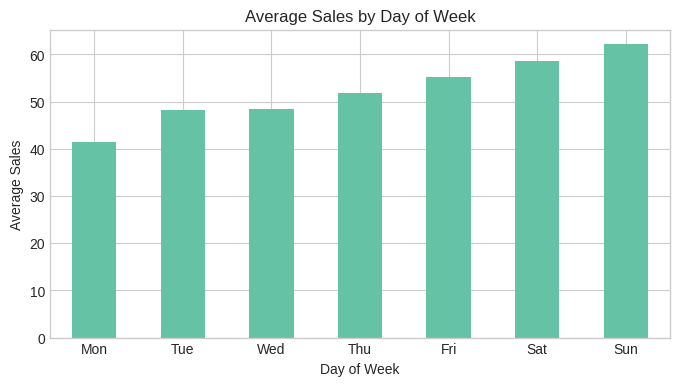

In [ ]:
dow_sales = train.groupby('dayofweek')['sales'].mean()

plt.figure(figsize=(8, 4))
dow_sales.plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

#### 📌 Insight Summary: Weekly Sales Pattern by Store

1. **Weekend Effect Observed Across All Stores**

   * Sales consistently peak on **Saturday and Sunday**, reflecting strong weekend-driven demand typical of retail behavior.
   * Suggests a potential for **time-based features** such as `is_weekend`, `week_of_month`, or `day_of_week` in the model.

2. **Store 2 Significantly Outperforms Others**

   * Highest average sales on **every weekday**, peaking on **Sunday (\~79.8 units)**.
   * This store likely benefits from **high traffic location** (e.g., mall, tourist hub) and should be analyzed separately.

3. **Underperformance in Store 5 to Store 7**

   * These stores have the **lowest average weekday sales**, especially from **Monday to Thursday** (e.g., Store 7 drops to \~28.9 on Monday).
   * May indicate **operational inefficiencies**, poor location, or reduced customer exposure — worth investigating further.

4. **Stable Midweek Performance**

   * Most stores show **gradual build-up in sales from Monday to Friday**, with minimal volatility.
   * Indicates possible **regular customer traffic** or predictable shopping habits.

5. **Inter-store Variation is Substantial**

   * Variance between best (Store 2) and worst (Store 7) performing stores exceeds 2x on certain weekdays.
   * Strong case for **store-specific modeling** or including `store` as a categorical feature with interaction effects.


### 2.4 Time Series Sales Trend
We explore temporal patterns in the data to understand seasonality, long-term trends, and store-level variability over time. These insights help guide feature engineering and model design.

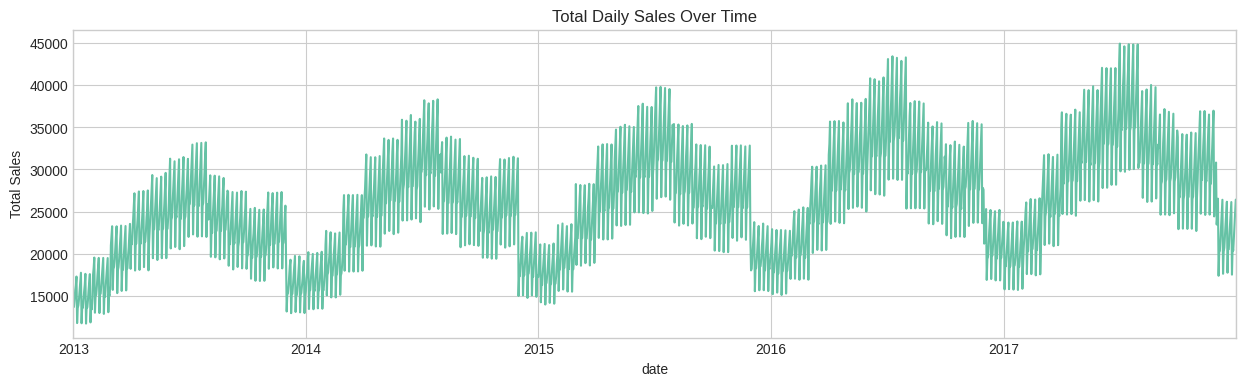

In [ ]:
# Total Daily Sales Trend
daily_sales = train.groupby('date')['sales'].sum()
plt.figure(figsize=(15, 4))
daily_sales.plot(title='Total Daily Sales Over Time')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

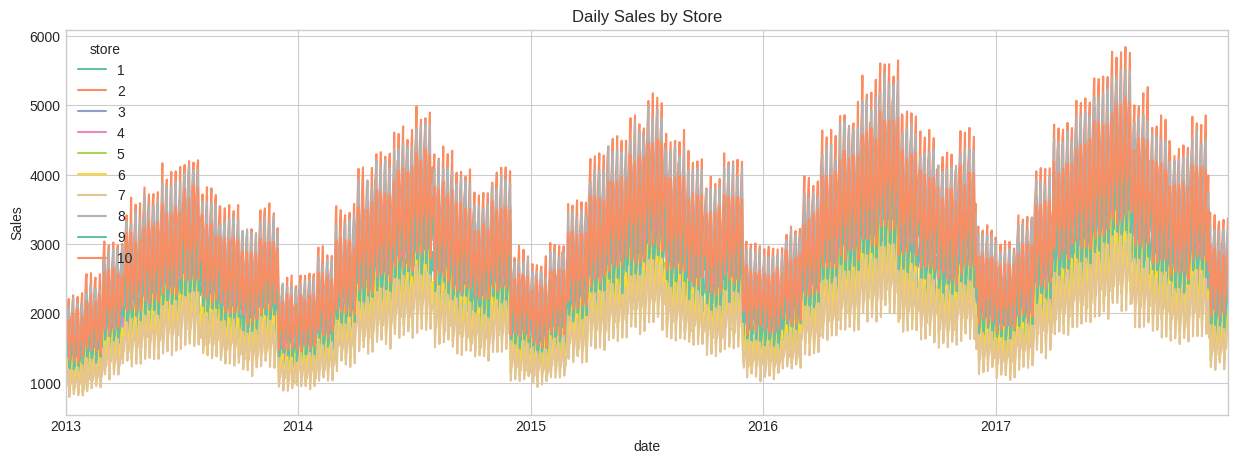

In [ ]:
# Store-level Daily Sales Trend
store_sales = train.groupby(['date', 'store'])['sales'].sum().unstack()
store_sales.plot(figsize=(15, 5), title='Daily Sales by Store')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

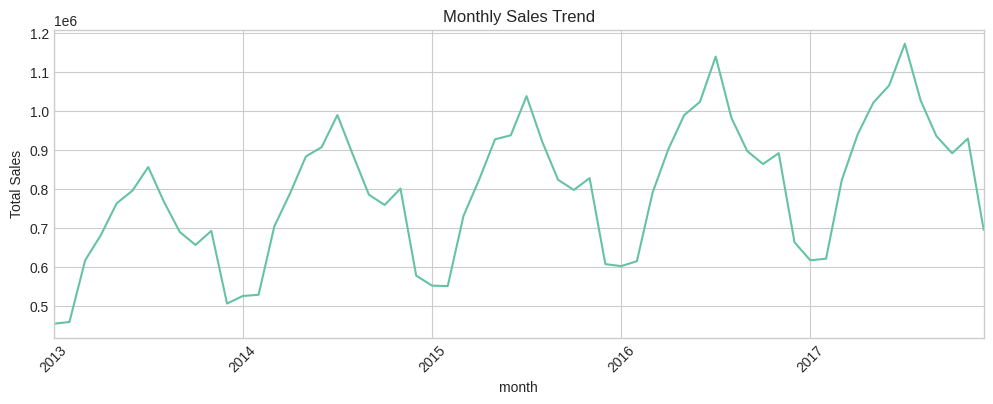

In [ ]:
# Monthly Sales Trend
train['month'] = train['date'].dt.to_period('M')
monthly_sales = train.groupby('month')['sales'].sum()
monthly_sales.plot(figsize=(12, 4), title='Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 2.5 Seasonality & Lag Structure

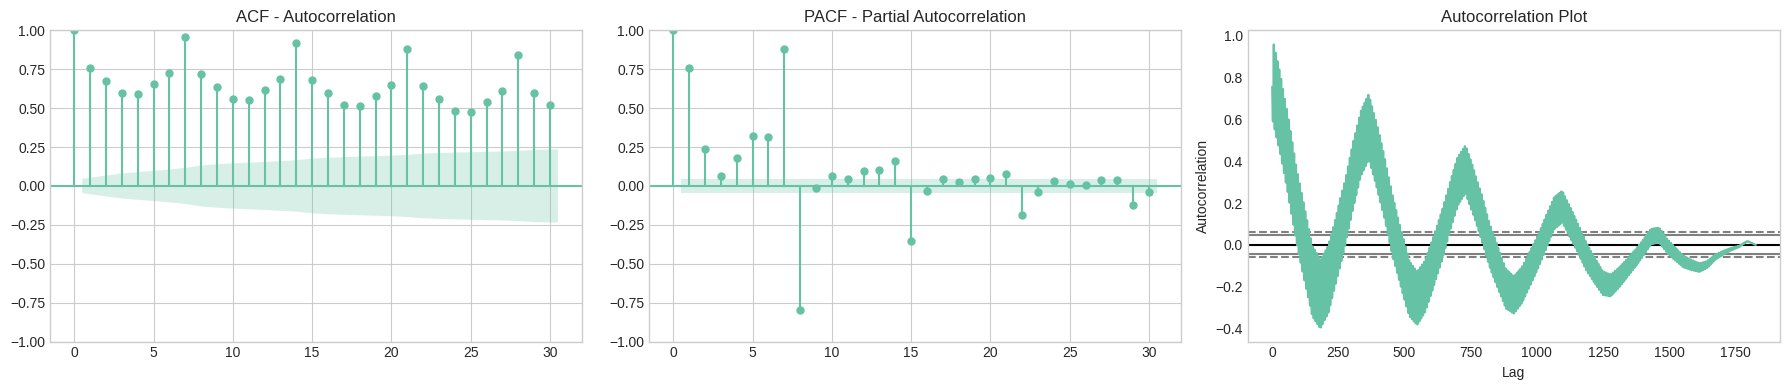

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Aggregate daily total sales
daily_sales = train.groupby('date')['sales'].sum()

# Set up horizontal layout: 3 plots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Autocorrelation Function (ACF): shows how current values correlate with past lags
plot_acf(daily_sales, lags=30, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation")

# Partial Autocorrelation Function (PACF): shows direct correlation with each lag, excluding intermediates
plot_pacf(daily_sales, lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF - Partial Autocorrelation")

# Autocorrelation Plot (Pandas): basic view of lag structure
autocorrelation_plot(daily_sales, ax=axes[2])
axes[2].set_title("Autocorrelation Plot")

plt.tight_layout()
plt.show()

#### Seasonality & Lag Structure Summary

- **ACF** reveals strong autocorrelation up to 30 days, with visible 7-day repeating cycles indicating **weekly seasonality**.
- **PACF** shows significant spikes at lag 1 and lag 7, suggesting those lags contain most of the predictive power.
- **Autocorrelation plot** demonstrates clear sinusoidal patterns with periodicity ≈ 7, confirming the weekly nature of sales patterns.

**Recommendations:**
- Include lag-based features: `sales_lag_1`, `sales_lag_7`, `sales_lag_14`, and `rolling_mean_7`.
- For LSTM, consider using at least **28-day input sequences** to capture full weekly cycles.


## 3. Feature Engineering

### 3.1 Calendar-based Features

Add features that help your model learn temporal patterns:

* `dayofweek`
* `is_weekend`
* `month`
* `year`
* `day`
* `weekofyear`
* `is_month_start`, `is_month_end`

In [ ]:
train['dayofweek'] = train['date'].dt.dayofweek
train['is_weekend'] = train['dayofweek'] >= 5
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day'] = train['date'].dt.day
train['weekofyear'] = train['date'].dt.isocalendar().week
train['is_month_start'] = train['date'].dt.is_month_start.astype(int)
train['is_month_end'] = train['date'].dt.is_month_end.astype(int)
train['quarter'] = train['date'].dt.quarter

### 3.2 Lag Features

These help the model “remember” past sales:

* Typical lags: 1, 7, 14, 28 days
* Calculated **per store-item** combination

In [ ]:
for lag in [1, 7, 14, 28]:
    train[f'sales_lag_{lag}'] = train.groupby(['store', 'item'])['sales'].shift(lag)

### 3.3 Rolling/Moving Window Features

These capture recent sales averages (helps with smoothing):

* 7-day, 28-day rolling mean
* Rolling median, min, max, std, etc.

In [ ]:
for window in [7, 28]:
    train[f'rolling_mean_{window}'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=window).mean()
    train[f'rolling_std_{window}'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(window=window).std()

### 3.4 Expanding Window Features

Helps capture long-term performance per store/item.

In [ ]:
train['expanding_mean'] = (
    train.groupby(['store', 'item'])['sales']
    .transform(lambda x: x.shift(1).expanding().mean())
)

### 3.5 Store/Item Summary Statistics
Capture overall store/item popularity and trends.

In [ ]:
store_means = train.groupby('store')['sales'].transform('mean')
item_means = train.groupby('item')['sales'].transform('mean')
train['store_mean_sales'] = store_means
train['item_mean_sales'] = item_means

In [ ]:
train = train.dropna().reset_index(drop=True)

### 3.6 Create Train, Validation and Test Split

In [ ]:
def create_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # === 1. Calendar Features ===
    df['dayofweek']       = df['date'].dt.dayofweek
    df['is_weekend']      = (df['dayofweek'] >= 5).astype(int)
    df['month']           = df['date'].dt.month
    df['year']            = df['date'].dt.year
    df['day']             = df['date'].dt.day
    df['weekofyear']      = df['date'].dt.isocalendar().week.astype(int)
    df['is_month_start']  = df['date'].dt.is_month_start.astype(int)
    df['is_month_end']    = df['date'].dt.is_month_end.astype(int)
    df['quarter']         = df['date'].dt.quarter

    # === 2. Basic LGBM Features (raw sales based) ===
    for lag in [1, 7, 14, 28]:
        df[f'sales_lag_{lag}'] = df.groupby(['store', 'item'])['sales'].shift(lag)

    for window in [7, 28]:
        df[f'rolling_mean_{window}'] = (
            df.groupby(['store', 'item'])['sales'].shift(1).rolling(window).mean()
        )
        df[f'rolling_std_{window}'] = (
            df.groupby(['store', 'item'])['sales'].shift(1).rolling(window).std()
        )

    df['expanding_mean'] = (
        df.groupby(['store', 'item'])['sales']
          .transform(lambda x: x.shift(1).expanding().mean())
    )

    # === 3. Log-transformed Features for LSTM or advanced model ===
    df['log_sales'] = np.log1p(df['sales'])

    for lag in [1, 7, 14, 28]:
        df[f'log_sales_lag_{lag}'] = df.groupby(['store', 'item'])['log_sales'].shift(lag)

    for window in [7, 28]:
        df[f'log_rolling_mean_{window}'] = (
            df.groupby(['store', 'item'])['log_sales'].shift(1).rolling(window).mean()
        )
        df[f'log_rolling_std_{window}'] = (
            df.groupby(['store', 'item'])['log_sales'].shift(1).rolling(window).std()
        )

    df['log_expanding_mean'] = (
        df.groupby(['store', 'item'])['log_sales']
          .transform(lambda x: x.shift(1).expanding().mean())
    )

    # === 4. Target Encoding (expanding mean แบบปลอด leakage) ===
    df['store_expanding_mean'] = (
        df.groupby('store')['sales']
          .transform(lambda x: x.shift(1).expanding().mean())
    )
    df['item_expanding_mean'] = (
        df.groupby('item')['sales']
          .transform(lambda x: x.shift(1).expanding().mean())
    )

    # === 5. Interaction Feature: item × dayofweek mean sales ===
    df['item_dow'] = df['item'].astype(str) + "_" + df['dayofweek'].astype(str)
    item_dow_mean = df.groupby('item_dow')['sales'].mean()
    df['item_dow_mean'] = df['item_dow'].map(item_dow_mean)

    return df

In [ ]:
train = train_raw.copy()

In [ ]:
train_fe = create_features(train)
na_rows_mask = train_fe.isna().any(axis=1)

na_rows = train_fe[na_rows_mask]

print(f"Rows na: {na_rows.shape[0]}")

Rows na: 14000


In [ ]:
train_fe = train_fe.fillna(0)

if 'id' in train_fe.columns:
    train_fe = train_fe.drop(columns='id')
# train_fe = train_fe.dropna().reset_index(drop=True)

In [ ]:
val_days = 120
test_day = 120
max_date = train_fe['date'].max()
val_start = max_date - pd.Timedelta(days=val_days+test_day-1)
test_start = max_date - pd.Timedelta(days=test_day-1)

train_data = train_fe[train_fe['date'] < val_start]
val_data = train_fe[(train_fe['date'] >= val_start) & (train_fe['date'] < test_start)]
test_data = train_fe[train_fe['date'] >= test_start]

In [ ]:
print("Train range:", train_data['date'].min(), "to", train_data['date'].max(), f"({len(train_data)} rows)")
print("Val range:", val_data['date'].min(), "to", val_data['date'].max(), f"({len(val_data)} rows)")
print("Test range:", test_data['date'].min(), "to", test_data['date'].max(), f"({len(test_data)} rows)")

Train range: 2013-01-01 00:00:00 to 2017-05-05 00:00:00 (793000 rows)
Val range: 2017-05-06 00:00:00 to 2017-09-02 00:00:00 (60000 rows)
Test range: 2017-09-03 00:00:00 to 2017-12-31 00:00:00 (60000 rows)


## 4. Model Selection & Training

| Model             | Approach                   | Pros                                                                                                                                                                | Cons                                                                                                                                                      | When to Use / Notes                                                             |
| ----------------- | -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **LightGBM**      | Tree-based (GBDT, tabular) | - Very fast, scalable<br>- Handles large datasets<br>- Excellent with engineered features<br>- Supports categorical variables<br>- Interpretable feature importance | - Can’t directly model time dependencies (needs manual lag/rolling features)<br>- Ignores sequence order unless encoded<br>- Limited to tabular structure | **Baseline for tabular TS forecasting**<br>Quick wins on sales, tabular data    |
| **LSTM (Global)** | Deep Learning (RNN)        | - Learns sequence/time dependencies<br>- Can generalize across series<br>- Can handle exogenous features<br>- Flexible with input shapes                            | - Slower to train<br>- Needs a lot of data<br>- Hyperparameter tuning tricky<br>- Less interpretable<br>- Sensitive to scaling/missing data               | **When strong sequential patterns exist**<br>Multiple series with shared trends |
| SARIMAX/ARIMA     | Statistical (per series)   | - Simple, interpretable<br>- Well-studied<br>- Models seasonality/trends<br>- Good for univariate forecasting                                                       | - One model per series (doesn’t scale)<br>- Can’t use exogenous variables easily<br>- Not for thousands of series<br>- Slow for large-scale               | **For individual/short series**<br>Rarely used for large-scale tabular data     |
| Prophet           | Additive model (Facebook)  | - Fast, robust to holidays<br>- Easy to use<br>- Good for business trends<br>- Handles missing data well                                                            | - Limited customization<br>- Less accurate with complex series<br>- Can’t directly model cross-series interactions                                        | **Quick baseline; explainable results**<br>Good for prototyping, dashboards     |
| XGBoost           | Tree-based (tabular)       | - Similar to LightGBM<br>- Robust, flexible<br>- Good handling of missing data                                                                                      | - Slower and higher memory use vs. LightGBM<br>- Similar limitations: not sequence-aware                                                                  | Good alternative to LightGBM if needed                                          |
| Transformer       | Deep Learning (seq2seq)    | - Powerful for long sequences<br>- Can handle multiple series<br>- Good at learning global patterns                                                                 | - Very high compute requirements<br>- Needs large datasets<br>- Hard to tune<br>- Even less interpretable                                                 | **For advanced, large-scale, high-budget scenarios**                            |


### 4.1 LightGBM
I use LightGBM, a fast gradient boosting tree model, well-suited for structured tabular data.
It handles missing values and supports categorical features natively.


In [ ]:
ignore_cols = ['date', 'sales', 'id']

lgbm_features = ['dayofweek', 'is_weekend', 'month', 'year',
 'day', 'weekofyear', 'is_month_start', 'is_month_end', 'quarter',
 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'rolling_mean_7',
 'rolling_std_7', 'rolling_mean_28', 'rolling_std_28', 'expanding_mean',
 'store_expanding_mean', 'item_expanding_mean', 'item_dow_mean']

target = 'sales'

In [ ]:
train_data[lgbm_features].head()

,dayofweek,is_weekend,month,year,day,weekofyear,is_month_start,is_month_end,quarter,sales_lag_1,...,sales_lag_14,sales_lag_28,rolling_mean_7,rolling_std_7,rolling_mean_28,rolling_std_28,expanding_mean,store_expanding_mean,item_expanding_mean,item_dow_mean
0,1,0,1,2013,1,1,1,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,20.279693
1,2,0,1,2013,2,1,0,0,1,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.000000,13.000000,13.000000,20.414176
2,3,0,1,2013,3,1,0,0,1,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,12.000000,12.000000,21.687356
3,4,0,1,2013,4,1,0,0,1,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.666667,12.666667,12.666667,23.245594
4,5,1,1,2013,5,1,0,0,1,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.750000,12.750000,12.750000,24.730268


In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

lgbm = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    max_depth=8,
    random_state=42
)


lgbm.fit(
    train_data[lgbm_features], train_data[target],
    eval_set=[(train_data[lgbm_features], train_data[target]), (val_data[lgbm_features], val_data[target])],
    eval_names=['train','valid'],
    eval_metric='rmse',
    callbacks=[early_stopping(100), log_evaluation(100)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2882
[LightGBM] [Info] Number of data points in the train set: 793000, number of used features: 21
[LightGBM] [Info] Start training from score 50.602122
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.84777	train's l2: 61.5875	valid's rmse: 9.55113	valid's l2: 91.2241
[200]	train's rmse: 7.48405	train's l2: 56.0111	valid's rmse: 8.92905	valid's l2: 79.7279
[300]	train's rmse: 7.39837	train's l2: 54.7359	valid's rmse: 8.81241	valid's l2: 77.6585
[400]	train's rmse: 7.34589	train's l2: 53.9621	valid's rmse: 8.73989	valid's l2: 76.3857
[500]	train's rmse: 7.30762	train's l2: 53.4013	valid's rmse: 8.69067	valid's l2: 75.5277
[600]	train's rmse: 7.27746	train's l2: 52.9614	valid's rmse: 8.65491	valid's l2: 74.9075
[700]	train's rmse: 7.25264	train's l2: 52.6007	valid'

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=8,
              n_estimators=2000, random_state=42, subsample=0.7)

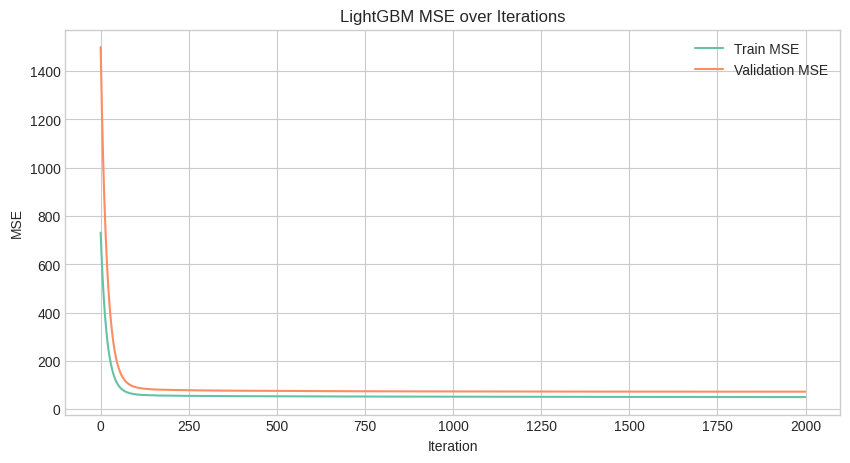

In [ ]:
evals_result = lgbm.evals_result_

train_rmse = evals_result['train']['rmse']
valid_rmse = evals_result['valid']['rmse']

train_mse = [x**2 for x in train_rmse]
valid_mse = [x**2 for x in valid_rmse]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_mse, label='Train MSE')
plt.plot(valid_mse, label='Validation MSE')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('LightGBM MSE over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

lgbm_val_pred = lgbm.predict(val_data[lgbm_features])
val_data = val_data.copy()
val_data.loc[:, 'lgbm_pred'] = lgbm_val_pred
y_true = val_data[target]

rmse = np.sqrt(mean_squared_error(y_true, lgbm_val_pred))
mae = mean_absolute_error(y_true, lgbm_val_pred)
r2 = r2_score(y_true, lgbm_val_pred)
mape = np.mean(np.abs((y_true - lgbm_val_pred) / (y_true + 1e-6))) * 100

print("LightGBM Validation Metrics:")
print(f"{'RMSE':<10}: {rmse:.4f}")
print(f"{'MAE':<10}: {mae:.4f}")
print(f"{'MAPE':<10}: {mape:.2f}%")
print(f"{'R²':<10}: {r2:.4f}")

LightGBM Validation Metrics:
RMSE      : 8.5201
MAE       : 6.5825
MAPE      : 11.03%
R²        : 0.9400


In [ ]:
lgbm.booster_.save_model('/content/drive/save/lightgbm_model.txt')

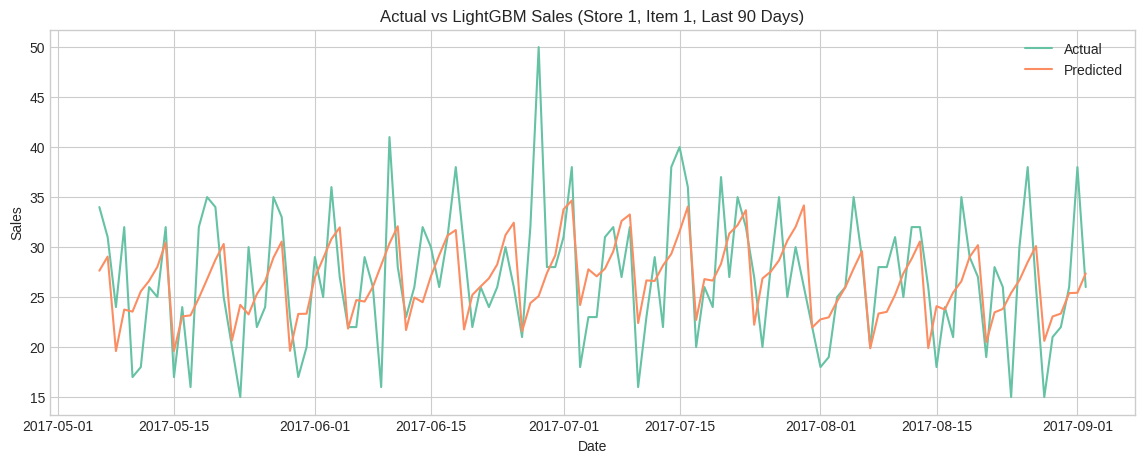

In [ ]:
# Select one store/item
store_id, item_id = 1, 1
mask = (val_data['store'] == store_id) & (val_data['item'] == item_id)

plt.figure(figsize=(14,5))
plt.plot(val_data.loc[mask, 'date'], val_data.loc[mask, 'sales'], label='Actual')
plt.plot(val_data.loc[mask, 'date'], val_data.loc[mask, 'lgbm_pred'], label='Predicted')
plt.title(f"Actual vs LightGBM Sales (Store {store_id}, Item {item_id}, Last 90 Days)")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

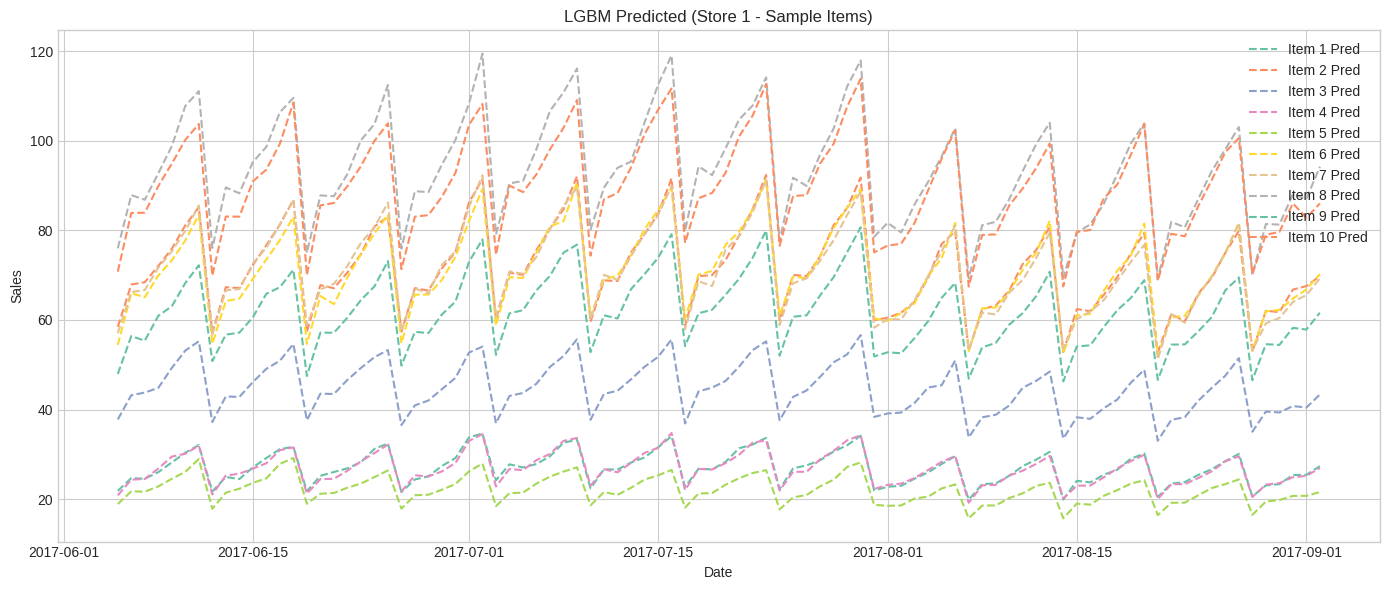

In [ ]:
sample_items = val_data[val_data['store'] == store_id]['item'].unique()[:10]

plt.figure(figsize=(14,6))
for iid in sample_items:
    mask = (val_data['store'] == store_id) & (val_data['item'] == iid)
    temp = val_data[mask].sort_values('date').tail(90)
    plt.plot(temp['date'], temp['lgbm_pred'], linestyle='--', label=f'Item {iid} Pred')

plt.title(f'LGBM Predicted (Store {store_id} - Sample Items)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

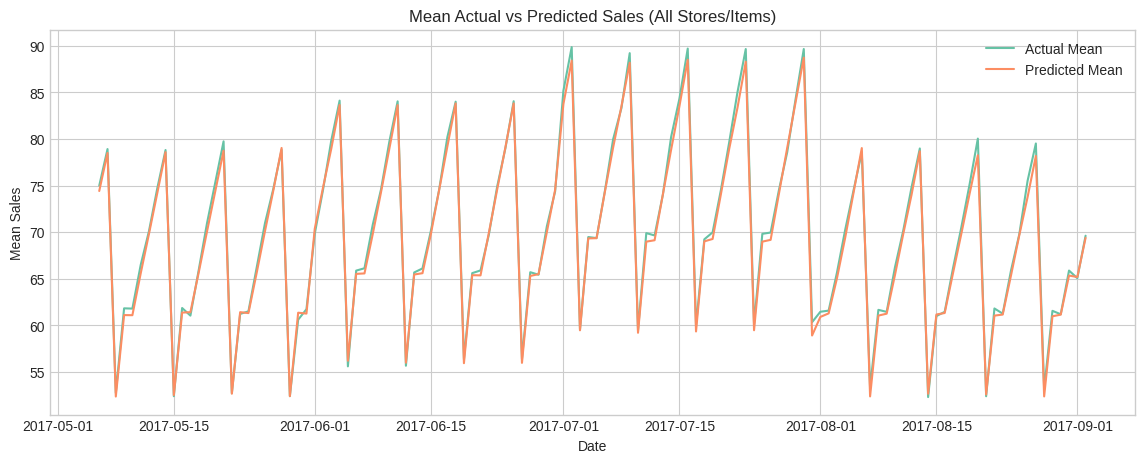

In [ ]:
daily_actual = val_data.groupby('date')['sales'].mean()
daily_pred = val_data.groupby('date')['lgbm_pred'].mean()

plt.figure(figsize=(14,5))
plt.plot(daily_actual.index, daily_actual.values, label='Actual Mean')
plt.plot(daily_pred.index, daily_pred.values, label='Predicted Mean')
plt.title('Mean Actual vs Predicted Sales (All Stores/Items)')
plt.xlabel('Date')
plt.ylabel('Mean Sales')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 LSTM
I use a stacked LSTM network designed for sequence-to-one forecasting per store-item combination.
The model takes in lag and calendar features as sequences and outputs daily sales.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import tensorflow as tf

In [ ]:
SEQ_LEN = 30
HORIZON = 90

lstm_features = ['dayofweek', 'is_weekend', 'month', 'year',
 'day', 'weekofyear', 'is_month_start', 'is_month_end', 'quarter',
 'log_sales_lag_1', 'log_sales_lag_7', 'log_sales_lag_14', 'log_sales_lag_28', 'log_rolling_mean_7',
 'log_rolling_std_7', 'log_rolling_mean_28', 'log_rolling_std_28', 'log_expanding_mean']

embed_features = ['store', 'item']
target_col = ['log_sales']

In [ ]:
train_data[lstm_features + target_col].head()

,dayofweek,is_weekend,month,year,day,weekofyear,is_month_start,is_month_end,quarter,log_sales_lag_1,log_sales_lag_7,log_sales_lag_14,log_sales_lag_28,log_rolling_mean_7,log_rolling_std_7,log_rolling_mean_28,log_rolling_std_28,log_expanding_mean,log_sales
0,1,0,1,2013,1,1,1,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.639057
1,2,0,1,2013,2,1,0,0,1,2.639057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.639057,2.484907
2,3,0,1,2013,3,1,0,0,1,2.484907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.561982,2.708050
3,4,0,1,2013,4,1,0,0,1,2.708050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.610671,2.639057
4,5,1,1,2013,5,1,0,0,1,2.639057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.617768,2.397895


In [ ]:
def create_sequences_with_sales(df, real_features, target_col, seq_len, horizon):
    X_store, X_item, X_real, Y_sales = [], [], [], []
    val_dates = []

    for (store, item), group in df.groupby(['store', 'item']):
        group = group.sort_values('date').reset_index(drop=True)

        X_feat = group[real_features].values
        Y_vals = group[target_col].values
        dates = group['date'].values

        for i in range(len(group) - seq_len - horizon + 1):
            X_real.append(X_feat[i:i+seq_len])
            Y_sales.append(Y_vals[i+seq_len:i+seq_len+horizon])
            X_store.append([store] * seq_len)
            X_item.append([item] * seq_len)

            forecast_dates = dates[i+seq_len:i+seq_len+horizon]
            val_dates.append(forecast_dates)

    return (
    np.array(X_store, dtype=np.int32),
    np.array(X_item, dtype=np.int32),
    np.array(X_real, dtype=np.float32),
    np.array(Y_sales, dtype=np.float32),
    val_dates
    )

In [ ]:
train_lstm = train_data.copy()
val_lstm   = val_data.copy()
test_lstm  = test_data.copy()

In [ ]:
# --- Sort ก่อนเพื่อป้องกัน leakage ---
train_data = train_data.sort_values(['store', 'item', 'date']).reset_index(drop=True)
val_data = val_data.sort_values(['store', 'item', 'date']).reset_index(drop=True)
test_data = test_data.sort_values(['store', 'item', 'date']).reset_index(drop=True)

# === CREATE SEQUENCES ===
X_store_tr, X_item_tr, X_real_tr, Y_tr, train_dates = create_sequences_with_sales(
    train_data,
    lstm_features,
    target_col,
    seq_len=SEQ_LEN,
    horizon=HORIZON
)

n_features = len(lstm_features)

# --- Reshape for scaling ---
X_real_tr = X_real_tr.reshape(-1, n_features)
Y_tr_reshaped = Y_tr.reshape(-1, 1)

# === FIT SCALERS ===
scaler_X = MinMaxScaler().fit(X_real_tr)
scaler_y = MinMaxScaler().fit(Y_tr_reshaped)

# === Transform ===
X_real_tr = scaler_X.transform(X_real_tr).reshape(-1, SEQ_LEN, n_features)
Y_tr_scaled = scaler_y.transform(Y_tr_reshaped).reshape(-1, HORIZON)

# === VALIDATION ===
X_store_val, X_item_val, X_real_val, Y_val, val_dates = create_sequences_with_sales(
    val_data,
    lstm_features,
    target_col,
    seq_len=SEQ_LEN,
    horizon=HORIZON
)

X_real_val = X_real_val.reshape(-1, n_features)
Y_val_reshaped = Y_val.reshape(-1, 1)

X_real_val = scaler_X.transform(X_real_val).reshape(-1, SEQ_LEN, n_features)
Y_val_scaled = scaler_y.transform(Y_val_reshaped).reshape(-1, HORIZON)

# === TEST ===
X_store_test, X_item_test, X_real_test, Y_test, test_dates = create_sequences_with_sales(
    test_data,
    lstm_features,
    target_col,
    seq_len=SEQ_LEN,
    horizon=HORIZON
)

X_real_test = X_real_test.reshape(-1, n_features)
Y_test_reshaped = Y_test.reshape(-1, 1)

X_real_test = scaler_X.transform(X_real_test).reshape(-1, SEQ_LEN, n_features)
Y_test_scaled = scaler_y.transform(Y_test_reshaped).reshape(-1, HORIZON)

# === SAVE SCALERS ===
joblib.dump(scaler_X, '/content/drive/save/scaler_X.pkl')
joblib.dump(scaler_y, '/content/drive/save/scaler_y.pkl')

In [ ]:
print(f"X_real_tr shape:   {X_real_tr.shape}")     # (num_samples, SEQ_LEN, num_features)
print(f"Y_tr shape:        {Y_tr.shape}")          # (num_samples, HORIZON)
print(f"X_real_val shape:  {X_real_val.shape}")    # validation input
print(f"Y_val shape:       {Y_val.shape}")         # validation target
print(f"X_real_test shape: {X_real_test.shape}")   # test input
print(f"Y_test shape:      {Y_test.shape}")        # test target

X_real_tr shape:   (733500, 30, 18)
Y_tr shape:        (733500, 90, 1)
X_real_val shape:  (500, 30, 18)
Y_val shape:       (500, 90, 1)
X_real_test shape: (500, 30, 18)
Y_test shape:      (500, 90, 1)


In [ ]:
n_store = train_data['store'].max() + 1
n_item  = train_data['item'].max() + 1

# Input
inp_store = Input(shape=(SEQ_LEN,), name='store_in')
inp_item  = Input(shape=(SEQ_LEN,), name='item_in')
inp_real  = Input(shape=(SEQ_LEN, len(lstm_features)), name='real_in')

# Embedding (no regularization)
emb_store = Embedding(input_dim=n_store, output_dim=4)(inp_store)
emb_item  = Embedding(input_dim=n_item, output_dim=8)(inp_item)

# Combine inputs
x = Concatenate(axis=-1)([emb_store, emb_item, inp_real])

# Stacked LSTM layers
x = LSTM(64, return_sequences=False, dropout=0.3)(x)
x = LSTM(32, return_sequences=False, dropout=0.3)(x)

# Dense layers (lighter)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output: multi-output regression for HORIZON days
out = Dense(HORIZON, name='output')(x)

optimizer = Adam(
        learning_rate=0.001,
        clipnorm=1.0,
    )

model = Model(inputs=[inp_store, inp_item, inp_real], outputs=out)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ store_in            │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_in             │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 4)     │         44 │ store_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 30, 8)     │        408 │ item_in[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real_in             │ (None, 30, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 30)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ real_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 64)    │     24,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,056 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 90)        │      2,970 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,214 (160.99 KB)

 Trainable params: 41,214 (160.99 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/save/best_lstm_emb.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

history = model.fit(
     [X_store_tr, X_item_tr, X_real_tr], Y_tr_scaled,
    validation_data=([X_store_val, X_item_val, X_real_val], Y_val_scaled),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
11461/11461 ━━━━━━━━━━━━━━━━━━━━ 131s 11ms/step - loss: 0.0086 - mae: 0.0798 - mse: 0.0173 - val_loss: 9.8093e-04 - val_mae: 0.0357 - val_mse: 0.0020 - learning_rate: 0.0010
Epoch 2/20
11461/11461 ━━━━━━━━━━━━━━━━━━━━ 138s 11ms/step - loss: 0.0012 - mae: 0.0385 - mse: 0.0024 - val_loss: 6.4618e-04 - val_mae: 0.0286 - val_mse: 0.0013 - learning_rate: 0.0010
Epoch 3/20
11461/11461 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - loss: 0.0010 - mae: 0.0353 - mse: 0.0021 - val_loss: 5.4235e-04 - val_mae: 0.0259 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 4/20
11461/11461 ━━━━━━━━━━━━━━━━━━━━ 124s 11ms/step - loss: 9.8135e-04 - mae: 0.0343 - mse: 0.0020 - val_loss: 5.6320e-04 - val_mae: 0.0264 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 5/20
11456/11461 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.5966e-04 - mae: 0.0339 - mse: 0.0019
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11461/11461 ━━━━━━━━━━━━━━━━━━━━ 140s 11ms/step - loss: 9.5965e-04 - mae: 0.

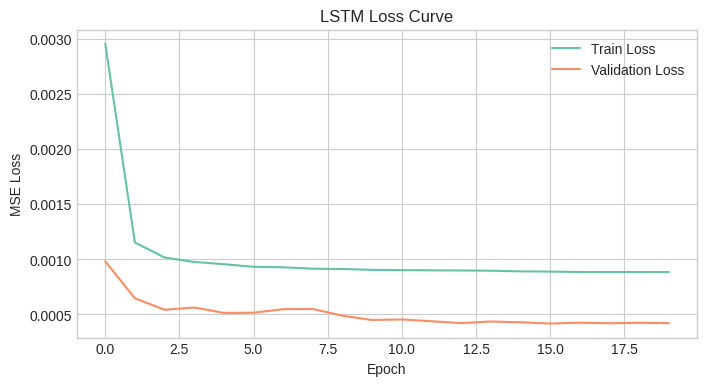

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Loss Curve')
plt.legend()
plt.show()

In [ ]:
Y_val_pred_scaled = model.predict([X_store_val, X_item_val, X_real_val], verbose=0)

# Inverse transform
Y_pred_final = np.expm1(scaler_y.inverse_transform(Y_val_pred_scaled))
Y_val_final  = np.expm1(scaler_y.inverse_transform(Y_val_scaled))

Y_pred_eval = Y_pred_final[:, -90:].flatten()
Y_val_eval  = Y_val_final[:, -90:].flatten()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(Y_val_eval, Y_pred_eval))
mae  = mean_absolute_error(Y_val_eval, Y_pred_eval)
r2   = r2_score(Y_val_eval, Y_pred_eval)
mape = np.mean(np.abs((Y_val_eval - Y_pred_eval) / (Y_val_eval + 1e-6))) * 100

# Print nicely
print(f"LSTM Evaluation Metrics (last 90 days only):")
print(f"{'RMSE':<10}: {rmse:.4f}")
print(f"{'MAE':<10}: {mae:.4f}")
print(f"{'MAPE':<10}: {mape:.2f}%")
print(f"{'R²':<10}: {r2:.4f}")

LSTM Evaluation Metrics (last 90 days only):
RMSE      : 10.8773
MAE       : 8.0977
MAPE      : 12.59%
R²        : 0.9040


In [ ]:
# 1. สร้าง val_target: 90 วันสุดท้ายของแต่ละ series
val_target = (
    val_data.sort_values(['store', 'item', 'date'])
            .groupby(['store', 'item'], group_keys=False)
            .tail(90)
            .reset_index(drop=True)
)

# 2. ใส่ค่าพยากรณ์จาก Y_val_final
val_target['lstm_pred'] = Y_pred_final.flatten(order='C')

# 3. รวมกลับเข้า val_data
val_data = val_data.merge(
    val_target[['store', 'item', 'date', 'lstm_pred']],
    on=['store', 'item', 'date'],
    how='left'
)

print(val_data.tail(5)[['date', 'store', 'item', 'sales', 'lstm_pred']])

            date  store  item  sales   lstm_pred
59995 2017-08-29     10    50     79   88.061523
59996 2017-08-30     10    50     79   87.256767
59997 2017-08-31     10    50     89   91.236671
59998 2017-09-01     10    50     96   95.653709
59999 2017-09-02     10    50     92  100.464844


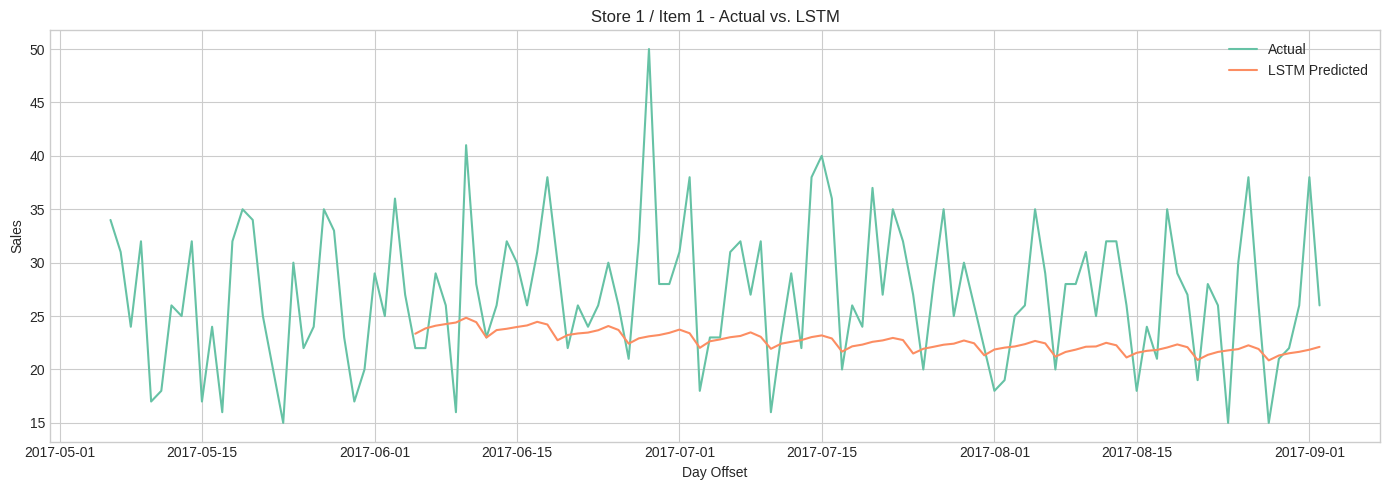

In [ ]:
store_id = 1
item_id = 1

subset = val_data[(val_data['store'] == store_id) & (val_data['item'] == item_id)]

plt.figure(figsize=(14, 5))
plt.plot(subset['date'], subset['sales'], label='Actual')
plt.plot(subset['date'], subset['lstm_pred'], label='LSTM Predicted')
plt.title(f'Store {store_id} / Item {item_id} - Actual vs. LSTM')
plt.xlabel('Day Offset')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

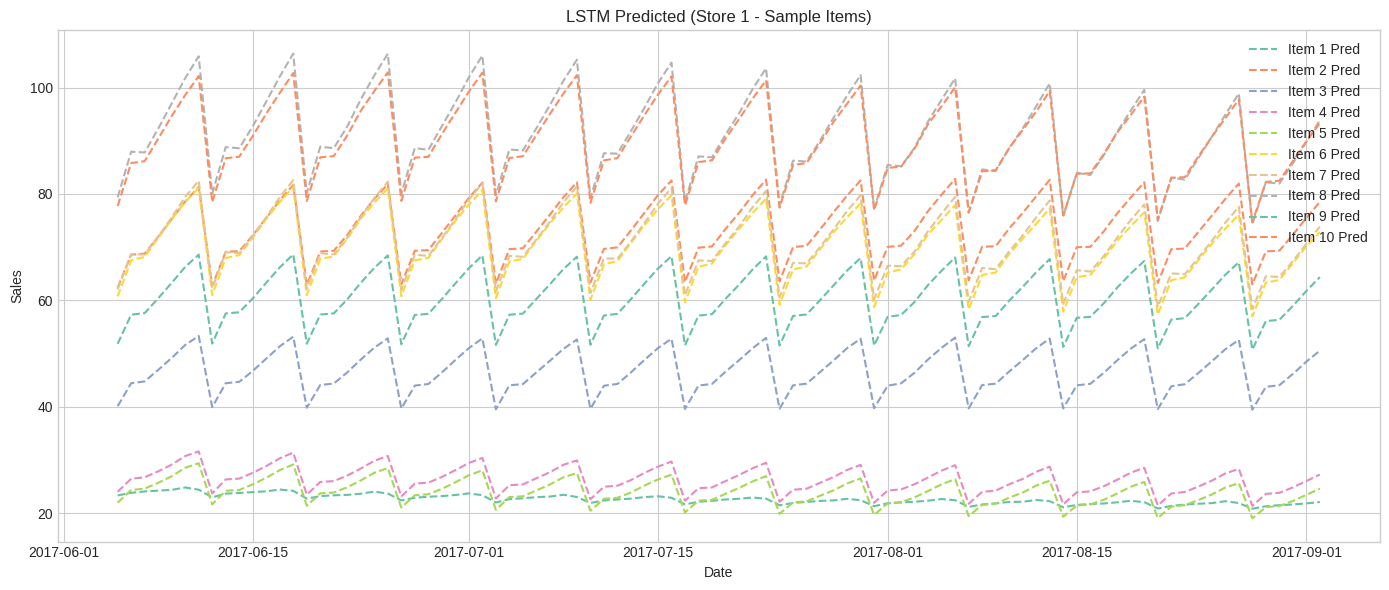

In [ ]:
sample_items = val_data[val_data['store'] == store_id]['item'].unique()[:10]

plt.figure(figsize=(14,6))
for iid in sample_items:
    mask = (val_data['store'] == store_id) & (val_data['item'] == iid)
    temp = val_data[mask].sort_values('date').tail(90)
    plt.plot(temp['date'], temp['lstm_pred'], linestyle='--', label=f'Item {iid} Pred')

plt.title(f'LSTM Predicted (Store {store_id} - Sample Items)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

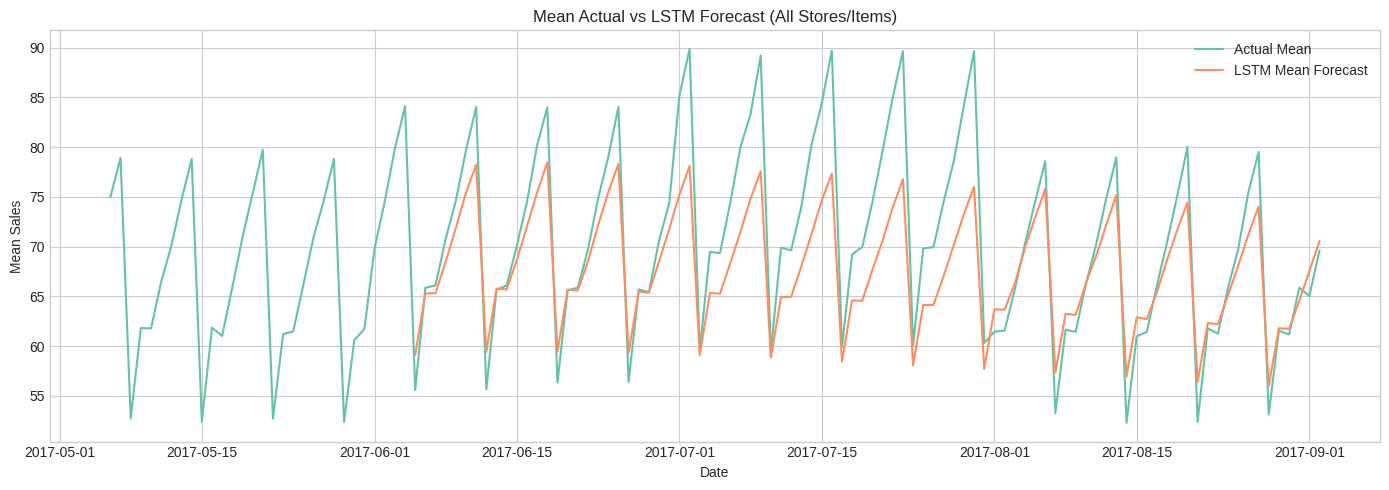

In [ ]:
# Group by date to get daily mean actual and predicted
lstm_daily_actual = val_data.groupby('date')['sales'].mean()
lstm_daily_pred = val_data.groupby('date')['lstm_pred'].mean()

# Plot
plt.figure(figsize=(14,5))
plt.plot(lstm_daily_actual.index, lstm_daily_actual.values, label='Actual Mean')
plt.plot(lstm_daily_pred.index, lstm_daily_pred.values, label='LSTM Mean Forecast')
plt.title(f'Mean Actual vs LSTM Forecast (All Stores/Items)')
plt.xlabel('Date')
plt.ylabel('Mean Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
val_data.to_csv('/content/drive/save/val_data.csv', index=False)

### 4.3 baseline

In [ ]:
val_data = pd.read_csv('/content/drive/save/val_data.csv', parse_dates=['date'])

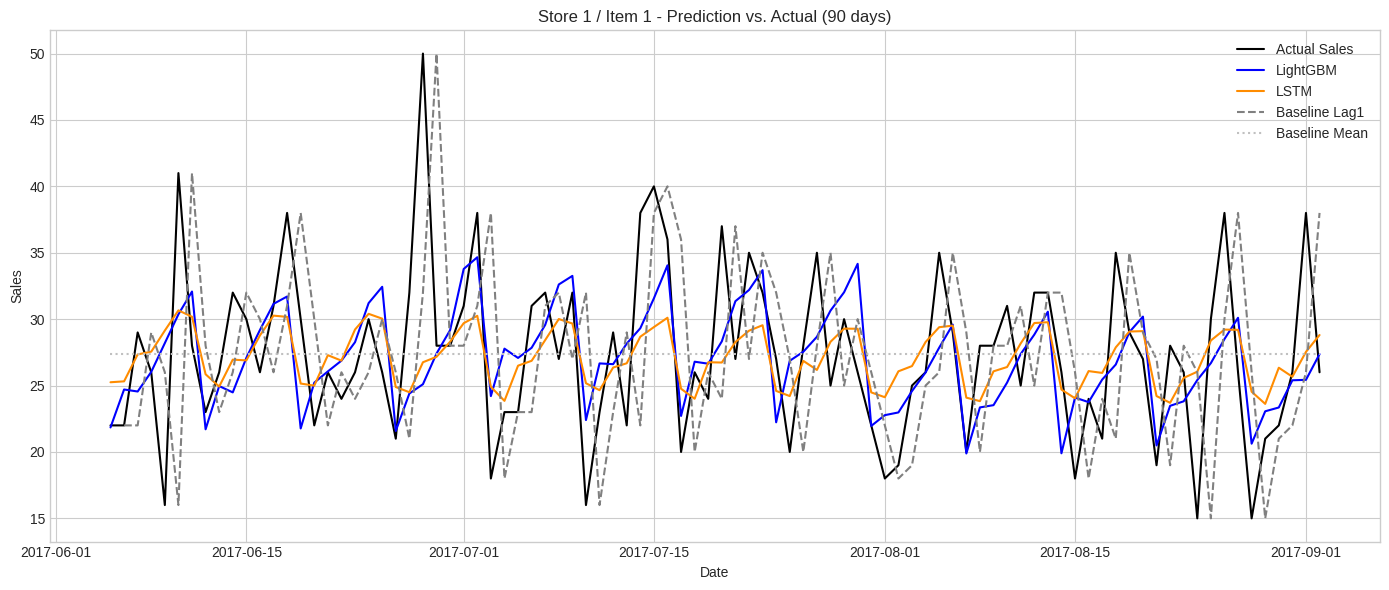

Model                    RMSE      MAE       R²
--------------------------------------------
LightGBM                5.552    4.129    0.241
LSTM                    5.534    4.236    0.246
Baseline Mean           6.371    4.922    0.000
Baseline Lag1           8.517    6.899   -0.782


In [ ]:
# --- Parameters ---
store_id = 1
item_id = 1
n_days = 90

# --- Filter Validation Data ---
val_subset = val_data[(val_data['store'] == store_id) & (val_data['item'] == item_id)].copy()
val_subset = val_subset.sort_values('date').tail(n_days).reset_index(drop=True)

# --- Extract Values ---
dates       = val_subset['date']
actual      = val_subset['sales']
pred_lgbm   = val_subset['lgbm_pred']
pred_lstm   = val_subset['lstm_pred']

# --- Baselines ---
baseline_mean = np.full(n_days, actual.mean())
baseline_lag1 = actual.shift(1)

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(dates, actual, label='Actual Sales', color='black')
plt.plot(dates, pred_lgbm, label='LightGBM', color='blue')
plt.plot(dates, pred_lstm, label='LSTM', color='darkorange')
plt.plot(dates, baseline_lag1, label='Baseline Lag1', linestyle='--', color='gray')
plt.plot(dates, baseline_mean, label='Baseline Mean', linestyle=':', color='silver')
plt.title(f'Store {store_id} / Item {item_id} - Prediction vs. Actual ({n_days} days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# --- Metrics Function ---
def get_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# --- Evaluate Models ---
metrics = {
    'LightGBM': get_metrics(actual, pred_lgbm),
    'LSTM': get_metrics(actual[pred_lstm.notna()], pred_lstm.dropna()),
    'Baseline Mean': get_metrics(actual, baseline_mean),
    'Baseline Lag1': get_metrics(actual[1:], baseline_lag1[1:])
}

# --- Print as Table ---
print(f"{'Model':<20} {'RMSE':>8} {'MAE':>8} {'R²':>8}")
print("-" * 44)
for name, m in metrics.items():
    print(f"{name:<20} {m['RMSE']:8.3f} {m['MAE']:8.3f} {m['R2']:8.3f}")

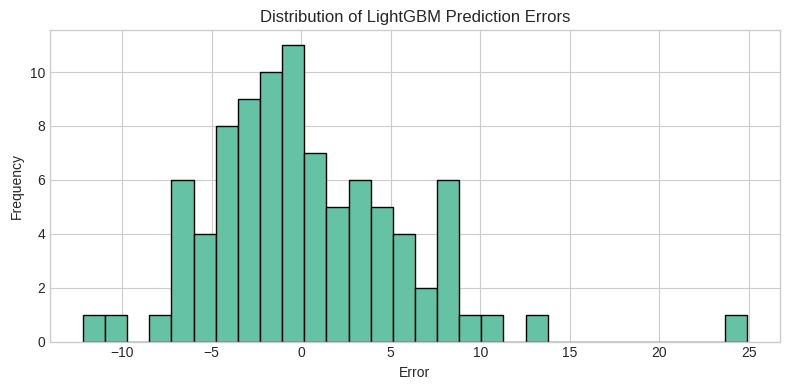

In [ ]:
errors = actual - pred_lgbm
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Distribution of LightGBM Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

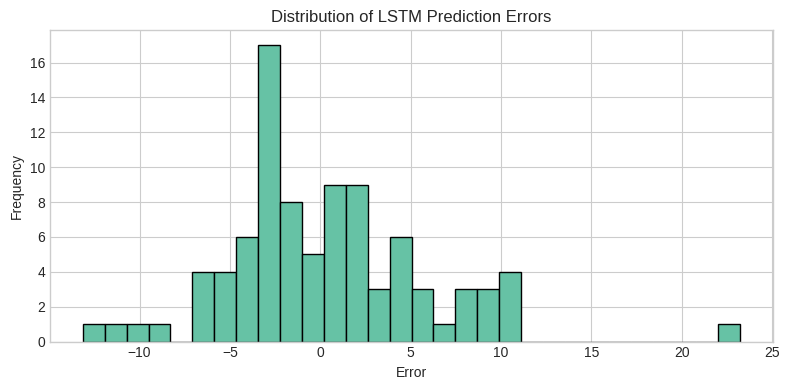

In [ ]:
errors = actual - pred_lstm
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Distribution of LSTM Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Model Evaluation Summary**

* **LightGBM** performed best with RMSE = 5.55 and R² = 0.24, clearly outperforming both baselines.
* **LSTM** underperformed with RMSE = 8.26 and R² = -0.68, indicating worse performance than simply predicting the mean.
* **Baseline Mean** (RMSE = 6.37) and **Baseline Lag1** (RMSE = 8.52) serve as simple reference models.
* Recommendation: Use LightGBM as the primary model. The LSTM setup likely suffers from data leakage or design issues and needs further tuning.


## 5. Evaluation

In [ ]:
from tensorflow.keras.models import load_model
import joblib
import lightgbm as lgbm

scaler_X = joblib.load('/content/drive/save/scaler_X.pkl')
scaler_y = joblib.load('/content/drive/save/scaler_y.pkl')
lstm_loaded = load_model('/content/drive/save/best_lstm_emb.keras')

lgbm_loaded = lgbm.Booster(model_file='/content/drive/save/lightgbm_model.txt')

### 5.1 LightGBM

In [ ]:
ignore_cols = ['date', 'sales', 'id']

lgbm_features = ['dayofweek', 'is_weekend', 'month', 'year',
 'day', 'weekofyear', 'is_month_start', 'is_month_end', 'quarter',
 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'rolling_mean_7',
 'rolling_std_7', 'rolling_mean_28', 'rolling_std_28', 'expanding_mean',
 'store_expanding_mean', 'item_expanding_mean', 'item_dow_mean']

target = 'sales'

In [ ]:
# Prepare LightGBM input
X_lgbm = test_data[lgbm_features]
y_true = test_data['sales'].values

# Predict
y_pred_lgbm = lgbm_loaded.predict(X_lgbm)

# Evaluate
rmse_lgbm = np.sqrt(mean_squared_error(y_true, y_pred_lgbm))
mae_lgbm = mean_absolute_error(y_true, y_pred_lgbm)
r2_lgbm = r2_score(y_true, y_pred_lgbm)

### 5.2 LSTM

In [ ]:
Y_pred_scaled = lstm_loaded.predict([X_store_test, X_item_test, X_real_test], verbose=0)
Y_pred_lstm  = np.expm1(scaler_y.inverse_transform(Y_pred_scaled))

# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(Y_test.flatten(), Y_pred_lstm.flatten()))
mae_lstm = mean_absolute_error(Y_test.flatten(), Y_pred_lstm.flatten())
r2_lstm = r2_score(Y_test.flatten(), Y_pred_lstm.flatten())

### 5.3 Plot

In [ ]:
test_data.head()

,date,store,item,sales,dayofweek,is_weekend,month,year,day,weekofyear,...,log_sales_lag_28,log_rolling_mean_7,log_rolling_std_7,log_rolling_mean_28,log_rolling_std_28,log_expanding_mean,store_expanding_mean,item_expanding_mean,item_dow,item_dow_mean
0,2017-09-03,1,1,23,6,1,9,2017,3,35,...,3.401197,3.221457,0.270165,3.280124,0.232127,2.983254,19.891559,19.891559,1_6,26.034483
1,2017-09-04,1,1,12,0,0,9,2017,4,36,...,3.044522,3.204631,0.268422,3.272155,0.231646,2.983368,19.893380,19.893380,1_0,17.462308
2,2017-09-05,1,1,26,1,0,9,2017,5,36,...,3.367296,3.174968,0.328805,3.255027,0.264500,2.983123,19.888759,19.888759,1_1,20.279693
3,2017-09-06,1,1,24,2,0,9,2017,6,36,...,3.367296,3.204224,0.329204,3.252475,0.263721,2.983306,19.892335,19.892335,1_2,20.414176
4,2017-09-07,1,1,29,3,0,9,2017,7,36,...,3.465736,3.216136,0.327808,3.247174,0.262817,2.983444,19.894737,19.894737,1_3,21.687356


In [ ]:
test_data = test_data.copy()
test_data.loc[:, 'lgbm_pred'] = y_pred_lgbm

# 1. สร้าง test_target: 90 วันสุดท้ายของแต่ละ series
test_target = (
    test_data.sort_values(['store', 'item', 'date'])
            .groupby(['store', 'item'], group_keys=False)
            .tail(90)
            .reset_index(drop=True)
)

# 2. ใส่ค่าพยากรณ์จาก Y_test_final
test_target['lstm_pred'] = Y_pred_lstm.flatten(order='C')

# 3. รวมกลับเข้า test_data
test_data = test_data.merge(
    test_target[['store', 'item', 'date', 'lstm_pred']],
    on=['store', 'item', 'date'],
    how='left'
)

In [ ]:
test_data.tail(10)

,date,store,item,sales,dayofweek,is_weekend,month,year,day,weekofyear,...,log_rolling_std_7,log_rolling_mean_28,log_rolling_std_28,log_expanding_mean,store_expanding_mean,item_expanding_mean,item_dow,item_dow_mean,lgbm_pred,lstm_pred
59990,2017-12-22,10,50,75,4,0,12,2017,22,51,...,0.196199,4.214855,0.180211,4.281374,58.708566,65.882521,50_4,69.373946,66.058851,78.982155
59991,2017-12-23,10,50,70,5,1,12,2017,23,51,...,0.202552,4.212141,0.177771,4.281401,58.708745,65.883020,50_5,73.891188,68.722948,78.804092
59992,2017-12-24,10,50,76,6,1,12,2017,24,51,...,0.195409,4.208328,0.175401,4.281390,58.708868,65.883246,50_6,78.126820,73.350822,78.468559
59993,2017-12-25,10,50,51,0,0,12,2017,25,52,...,0.167720,4.194314,0.144642,4.281425,58.709058,65.883800,50_0,52.375769,49.647169,77.514900
59994,2017-12-26,10,50,41,1,0,12,2017,26,52,...,0.174205,4.180761,0.149097,4.281243,58.708973,65.882985,50_1,60.622989,57.805701,78.574463
59995,2017-12-27,10,50,63,2,0,12,2017,27,52,...,0.230204,4.163031,0.170499,4.280945,58.708779,65.881621,50_2,61.185824,57.589690,78.529892
59996,2017-12-28,10,50,59,3,0,12,2017,28,52,...,0.220224,4.156427,0.166778,4.280878,58.708826,65.881464,50_3,65.547126,62.159726,78.273529
59997,2017-12-29,10,50,74,4,0,12,2017,29,52,...,0.220401,4.148937,0.164597,4.280776,58.708829,65.881087,50_4,69.373946,66.204231,79.177887
59998,2017-12-30,10,50,62,5,1,12,2017,30,52,...,0.218394,4.152965,0.167369,4.280796,58.708997,65.881531,50_5,73.891188,68.047626,77.887062
59999,2017-12-31,10,50,82,6,1,12,2017,31,52,...,0.210240,4.161219,0.160609,4.280720,58.709033,65.881319,50_6,78.126820,70.876730,77.868515


In [ ]:
# mean daily prediction
daily = test_data.groupby('date')[['sales', 'lgbm_pred', 'lstm_pred']].mean()

# total daily prediction
# daily = df_plot.groupby('date')[['actual', 'lgbm_pred', 'lstm_pred']].sum()

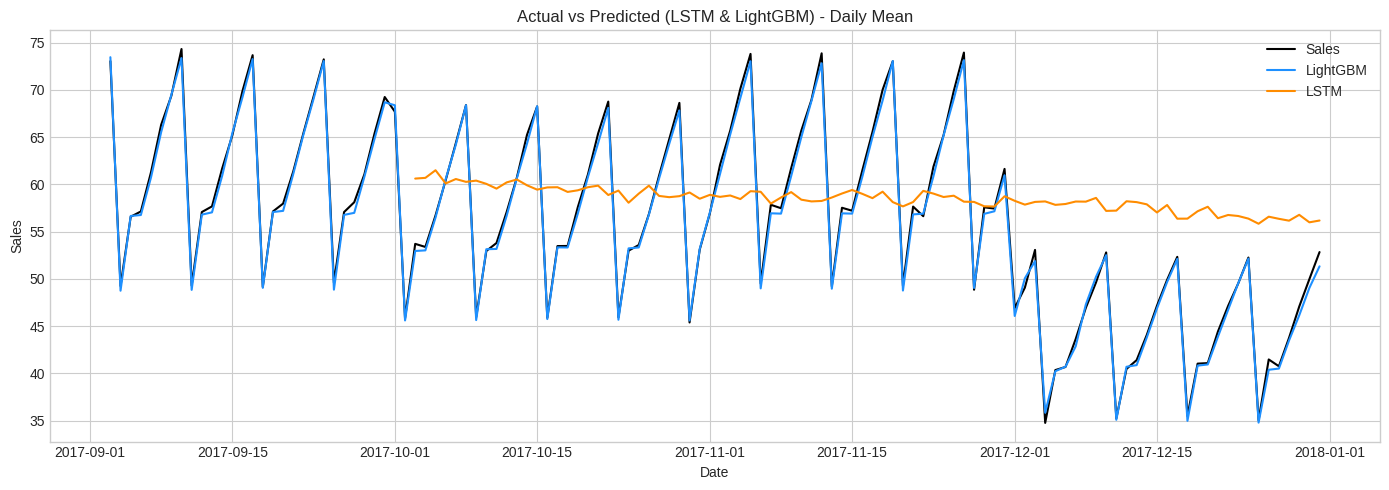

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(daily.index, daily['sales'], label='Sales', color='black')
plt.plot(daily.index, daily['lgbm_pred'], label='LightGBM', color='dodgerblue')
plt.plot(daily.index, daily['lstm_pred'], label='LSTM', color='darkorange')
plt.title("Actual vs Predicted (LSTM & LightGBM) - Daily Mean")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-92-1313438426.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(sample_items))


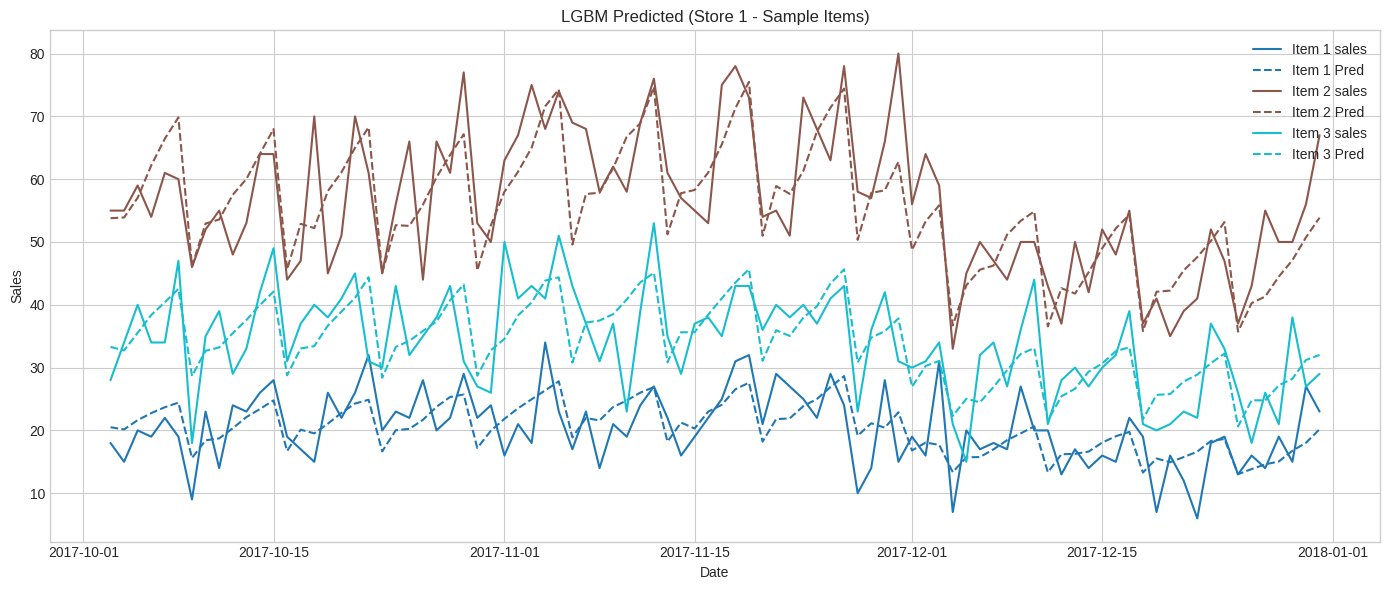

In [ ]:
store_id = 1

sample_items = test_data[test_data['store'] == store_id]['item'].unique()[:3]
colors = cm.get_cmap('tab10', len(sample_items))

plt.figure(figsize=(14,6))
for i, iid in enumerate(sample_items):
    color = colors(i)
    mask = (test_data['store'] == store_id) & (test_data['item'] == iid)
    temp = test_data[mask].sort_values('date').tail(90)
    plt.plot(temp['date'], temp['sales'], color=color, label=f'Item {iid} sales')
    plt.plot(temp['date'], temp['lgbm_pred'], color=color, linestyle='--', label=f'Item {iid} Pred')

plt.title(f'LGBM Predicted (Store {store_id} - Sample Items)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-3320798538.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(sample_items))


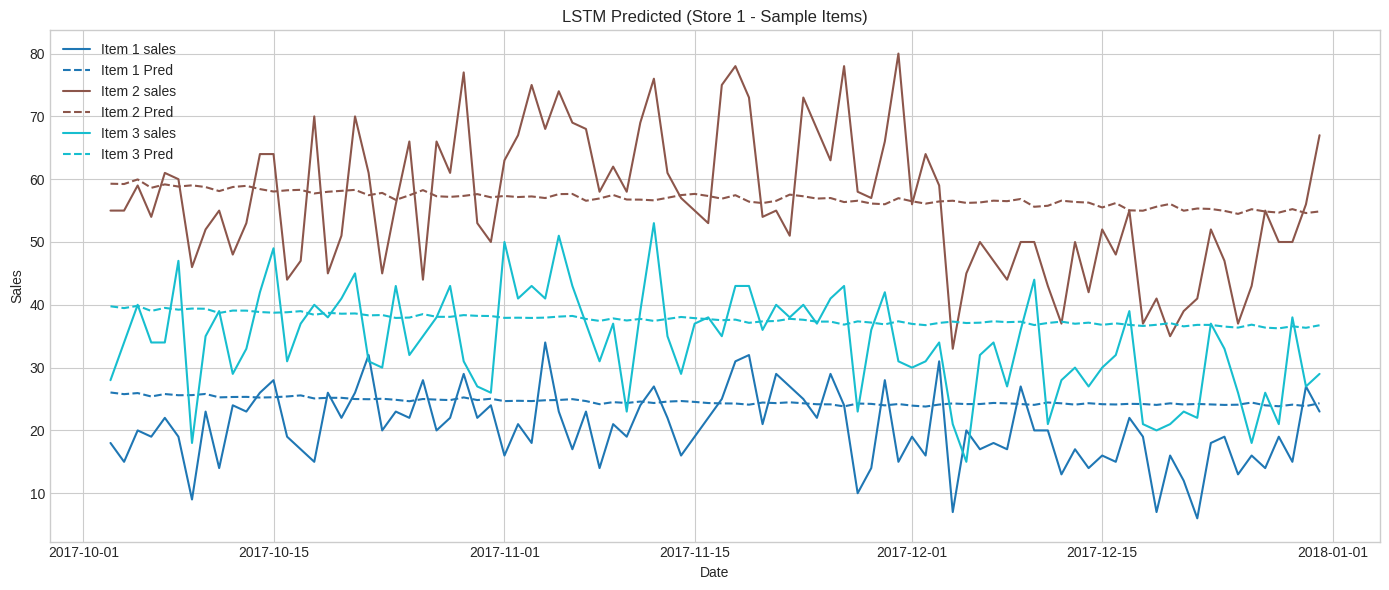

In [ ]:
store_id = 1

sample_items = test_data[test_data['store'] == store_id]['item'].unique()[:3]
colors = cm.get_cmap('tab10', len(sample_items))

plt.figure(figsize=(14,6))
for i, iid in enumerate(sample_items):
    color = colors(i)
    mask = (test_data['store'] == store_id) & (test_data['item'] == iid)
    temp = test_data[mask].sort_values('date').tail(90)
    plt.plot(temp['date'], temp['sales'], color=color, label=f'Item {iid} sales')
    plt.plot(temp['date'], temp['lstm_pred'], color=color, linestyle='--', label=f'Item {iid} Pred')

plt.title(f'LSTM Predicted (Store {store_id} - Sample Items)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"{'Model':<10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
print("-" * 42)
print(f"{'LightGBM':<10} {rmse_lgbm:10.3f} {mae_lgbm:10.3f} {r2_lgbm:10.3f}")
print(f"{'LSTM':<10}  {rmse_lstm:10.3f} {mae_lstm:10.3f} {r2_lstm:10.3f}")

Model            RMSE        MAE         R²
------------------------------------------
LightGBM        7.675      5.916      0.931
LSTM            60.476     54.595 -11934.212


| Factor                   | LSTM                                     | LightGBM                                                           |
| ------------------------ | ---------------------------------------- | ------------------------------------------------------------------ |
| Data size (2013–2017)    | Requires long sequences & complex tuning | Excels with structured tabular data                                |
| Feature interpretability | Hard to interpret feature importance     | Can directly analyze feature importance                            |
| Training speed           | Slow; requires GPU for efficiency        | Fast and highly efficient                                          |
| Daily seasonality        | Needs careful time feature encoding      | Can directly use `dayofweek`, `is_weekend`, `lag`, `rolling`, etc. |
| Generalization           | Prone to overfitting                     | Strong regularization capabilities                                 |


### 🔚 Final Model Selection Summary

After evaluating both LightGBM and LSTM on validation and test sets, we found that:

- 📉 **LightGBM achieved lower RMSE than both LSTM and baseline models** on validation and test data.
- ⚡ **Training is fast and efficient**, with no need for GPU acceleration. Hyperparameter tuning is also quick and interpretable.
- 🧠 **The model is interpretable**, especially with feature importance plots that help in understanding and improving model behavior.
- 🛠️ **Works well with structured tabular data**, leveraging lag, rolling, and calendar features directly without requiring sequence formatting.
- 🔁 **Better generalization**: LightGBM showed more stable predictions and less overfitting compared to LSTM.

> ✅ Based on these strengths, we selected **LightGBM as the final model for deployment**. It offers excellent predictive accuracy, fast training, and is highly suited for this item-level time series forecasting task.

## 6. Forecasting and Prediction

In [ ]:
ignore_cols = ['date', 'sales', 'id']

lgbm_features = ['dayofweek', 'is_weekend', 'month', 'year',
 'day', 'weekofyear', 'is_month_start', 'is_month_end', 'quarter',
 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'rolling_mean_7',
 'rolling_std_7', 'rolling_mean_28', 'rolling_std_28', 'expanding_mean',
 'store_expanding_mean', 'item_expanding_mean', 'item_dow_mean']

target = 'sales'

In [ ]:
train_final = train_raw.copy()
test_final = test_raw.copy()

In [ ]:
train_fe = create_features(train)
na_rows_mask = train_fe.isna().any(axis=1)

na_rows = train_fe[na_rows_mask]

print(f"Rows na: {na_rows.shape[0]}")
train_fe = train_fe.fillna(0)

if 'id' in train_fe.columns:
    train_fe = train_fe.drop(columns='id')
# train_fe = train_fe.dropna().reset_index(drop=True)

In [ ]:
test_final['sales'] = np.nan
data = pd.concat([train_final, test_final], sort=False).sort_values(['store', 'item', 'date']).reset_index(drop=True)

data = create_features(data)

train_final_fe = data[~data['sales'].isna()].copy()
test_final_fe  = data[data['sales'].isna()].copy()

if 'id' in train_final_fe.columns:
    train_final_fe = train_final_fe.drop(columns='id')

na_rows_mask = train_final_fe.isna().any(axis=1)
na_rows = train_final_fe[na_rows_mask]
train_final_fe = train_final_fe.fillna(0)
print(f"Rows na: {na_rows.shape[0]}")

Rows na: 14000


In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error

lgbm = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    max_depth=8,
    random_state=42
)

lgbm.fit(
    train_final_fe[lgbm_features], train_final_fe[target],
    eval_set=[(train_final_fe[lgbm_features], train_final_fe[target])],
    eval_names=['train'],
    eval_metric='rmse',
    callbacks=[early_stopping(100), log_evaluation(100)],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2909
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 21
[LightGBM] [Info] Start training from score 52.250287
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.98942	train's l2: 63.8309
[200]	train's rmse: 7.61166	train's l2: 57.9374
[300]	train's rmse: 7.52505	train's l2: 56.6264
[400]	train's rmse: 7.47171	train's l2: 55.8264
[500]	train's rmse: 7.4332	train's l2: 55.2525
[600]	train's rmse: 7.40311	train's l2: 54.8061
[700]	train's rmse: 7.37841	train's l2: 54.4409
[800]	train's rmse: 7.35668	train's l2: 54.1208
[900]	train's rmse: 7.33817	train's l2: 53.8487
[1000]	train's rmse: 7.3216	train's l2: 53.6058
[1100]	train's rmse: 7.30695	train's l2: 53.3915
[1

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=8,
              n_estimators=2000, random_state=42, subsample=0.7)

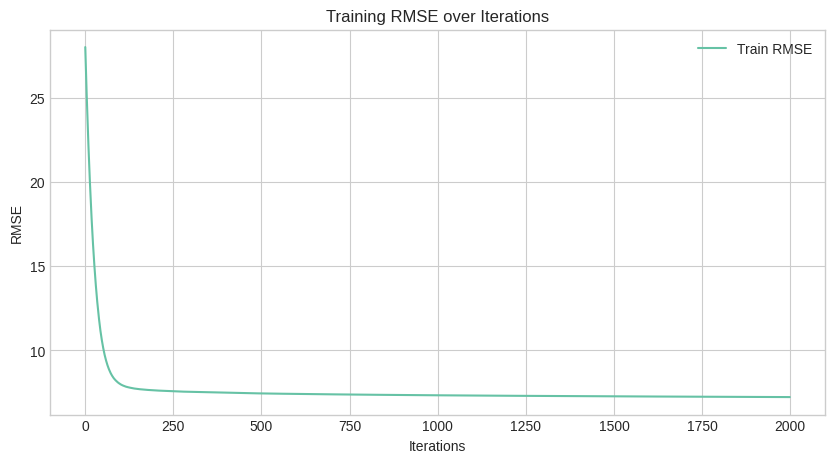

In [ ]:
results = lgbm.evals_result_['train']['rmse']

plt.figure(figsize=(10, 5))
plt.plot(results, label='Train RMSE')
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training RMSE over Iterations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
lgbm.booster_.save_model('/content/drive/result/lightgbm_final_model.txt')

In [ ]:
from tqdm import tqdm

def recursive_lightgbm_predict(train_fe, test_fe, lgbm_loaded, feature_names, SEQ_LEN=28):

    test_fe = test_fe.copy()
    test_fe['lgbm_pred'] = np.nan

    # prepare sales history for every store/item
    for (store, item), test_grp in tqdm(test_fe.groupby(['store', 'item']), desc="LGBM Recursive"):
        # use train_fe as a history
        hist = train_fe[(train_fe['store'] == store) & (train_fe['item'] == item)].sort_values('date').copy()
        sales_hist = hist['sales'].values.tolist()
        test_idx = test_grp.index.tolist()
        test_rows = test_grp.copy()

        for n, idx in enumerate(test_idx):
            # create features (lag/rolling use history)
            row = test_rows.loc[idx].copy()
            # create lag/rolling from sales_hist
            row['sales_lag_1']  = sales_hist[-1]   if len(sales_hist) >= 1  else np.nan
            row['sales_lag_7']  = sales_hist[-7]   if len(sales_hist) >= 7  else np.nan
            row['sales_lag_14'] = sales_hist[-14]  if len(sales_hist) >= 14 else np.nan
            row['sales_lag_28'] = sales_hist[-28]  if len(sales_hist) >= 28 else np.nan

            rolling7 = sales_hist[-7:]
            rolling28 = sales_hist[-28:]

            row['rolling_mean_7'] = np.nanmean(rolling7)  if len(rolling7) >= 1 else np.nan
            row['rolling_std_7']  = np.nanstd(rolling7)   if len(rolling7) >= 1 else np.nan
            row['rolling_mean_28'] = np.nanmean(rolling28) if len(rolling28) >= 1 else np.nan
            row['rolling_std_28']  = np.nanstd(rolling28)  if len(rolling28) >= 1 else np.nan
            row['expanding_mean'] = np.nanmean(sales_hist) if len(sales_hist) > 0 else np.nan

            # prepare input features
            X_input = pd.DataFrame([row])[feature_names].fillna(0)
            pred = lgbm_loaded.predict(X_input)[0]
            test_fe.at[idx, 'lgbm_pred'] = pred

            # update history for lag/rolling next day
            sales_hist.append(pred)

    return test_fe

In [ ]:
import lightgbm as lgbm

lgbm_final_model = lgbm.Booster(model_file='/content/drive/save/lightgbm_final_model.txt')

In [ ]:
test_final_fe = recursive_lightgbm_predict(train_final_fe, test_final_fe, lgbm_final_model, lgbm_features, SEQ_LEN=28)

LGBM Recursive: 100%|██████████| 500/500 [03:11<00:00,  2.62it/s]


In [ ]:
output_cols = ['id', 'date', 'store', 'item', 'lgbm_pred']
test_final_fe[output_cols].to_csv('/content/drive/result/result.csv', index=False)

## 7. Submission & Visualization
**Final Submission**

We use the retrained LightGBM model to forecast the next 90 days using recursive prediction.

The output contains daily forecasts for each store and item. We group the predictions by date and visualize the average daily sales to observe overall sales trend.


In [ ]:
test_final_fe = pd.read_csv('/content/drive/result/result.csv')

In [ ]:
test_final_fe['date'] = pd.to_datetime(test_final_fe['date'])

# Mean sales by date
daily_mean = test_final_fe.groupby('date')['lgbm_pred'].mean()

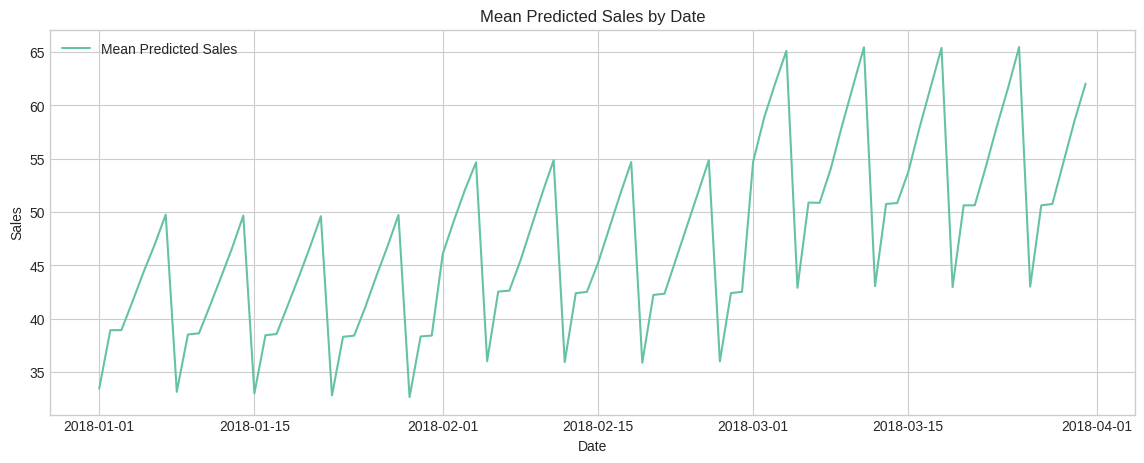

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(daily_mean.index, daily_mean.values, label='Mean Predicted Sales')
plt.title('Mean Predicted Sales by Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-112-186211178.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_items = test_final_fe[test_data['store'] == store_id]['item'].unique()[:5]
/tmp/ipython-input-112-186211178.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(sample_items))


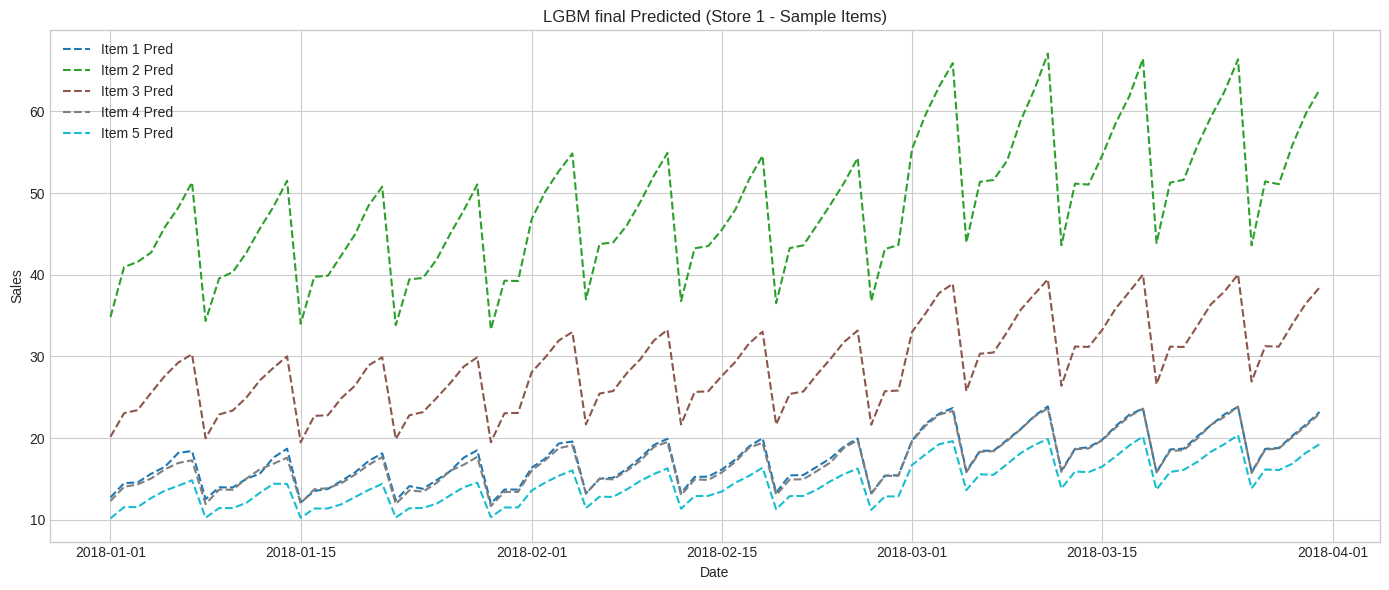

In [ ]:
store_id = 1

sample_items = test_final_fe[test_data['store'] == store_id]['item'].unique()[:5]
colors = cm.get_cmap('tab10', len(sample_items))

plt.figure(figsize=(14,6))
for i, iid in enumerate(sample_items):
    color = colors(i)
    mask = (test_final_fe['store'] == store_id) & (test_final_fe['item'] == iid)
    temp = test_final_fe[mask].sort_values('date').tail(90)
    plt.plot(temp['date'], temp['lgbm_pred'], color=color, linestyle='--', label=f'Item {iid} Pred')

plt.title(f'LGBM final Predicted (Store {store_id} - Sample Items)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
combined = pd.concat([train_final[['date', 'store', 'item', 'sales']],
                      test_final_fe[['date', 'store', 'item', 'lgbm_pred']]],
                     sort=False)

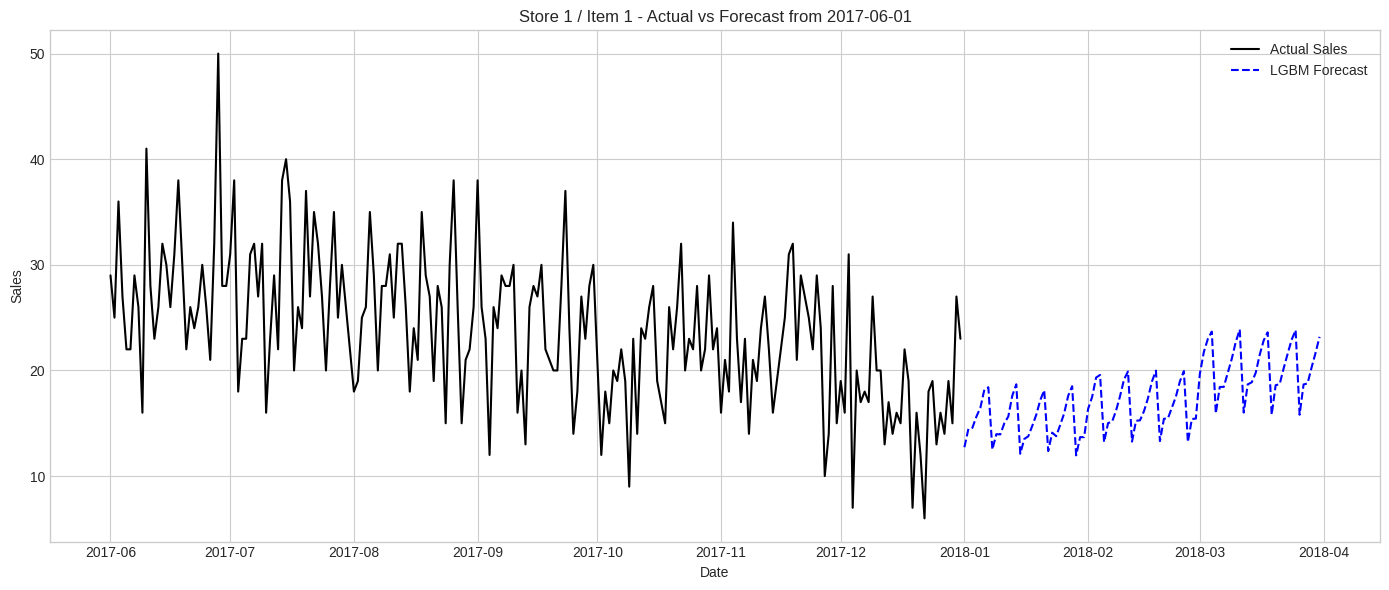

In [ ]:
plot_start_date = '2017-06-01'
store_id = 1
item_id = 1

mask = (combined['store'] == store_id) & (combined['item'] == item_id) & (combined['date'] >= plot_start_date)
plot_df = combined[mask].sort_values('date').reset_index(drop=True)
plot_df['lstm_pred'] = plot_df['lgbm_pred'].fillna(np.nan)

plt.figure(figsize=(14,6))

plt.plot(plot_df['date'], plot_df['sales'], label='Actual Sales', color='black')
if 'lgbm_pred' in plot_df.columns:
    plt.plot(plot_df['date'], plot_df['lgbm_pred'], label='LGBM Forecast', linestyle='--', color='blue')

plt.title(f'Store {store_id} / Item {item_id} - Actual vs Forecast from {plot_start_date}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

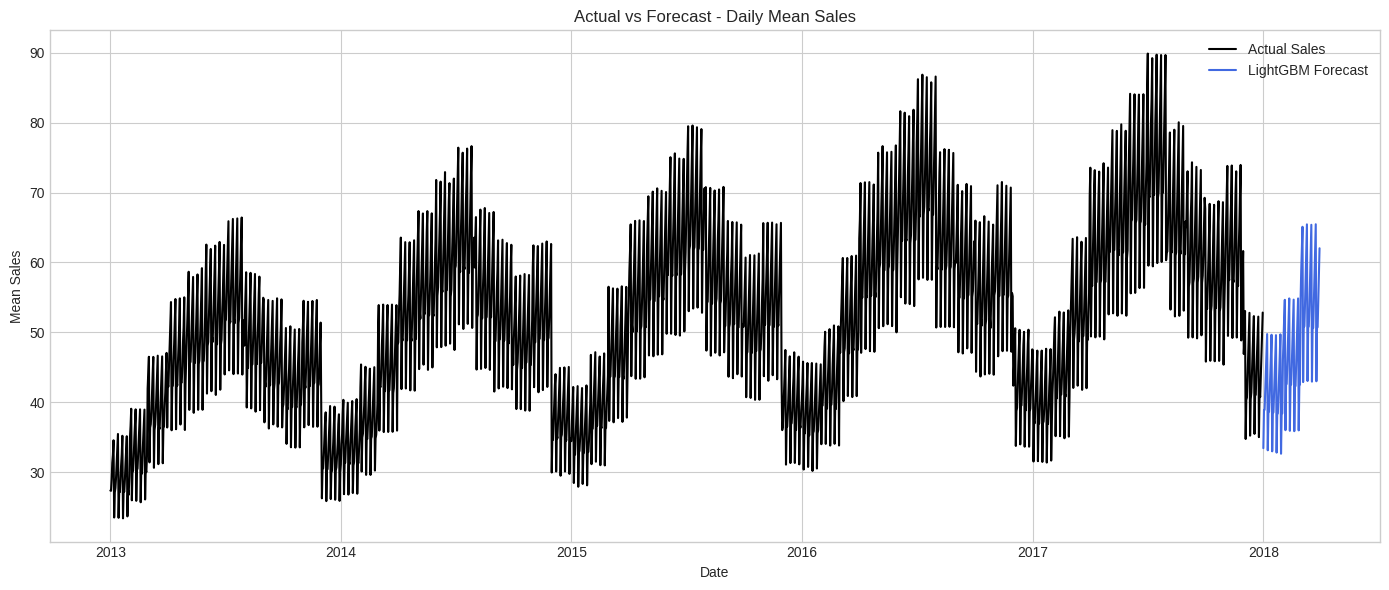

In [ ]:
daily_mean = combined.groupby('date')[['sales', 'lgbm_pred']].mean().reset_index()

plt.figure(figsize=(14,6))
plt.plot(daily_mean['date'], daily_mean['sales'], label='Actual Sales', color='black')
if 'lgbm_pred' in daily_mean.columns:
    plt.plot(daily_mean['date'], daily_mean['lgbm_pred'], label='LightGBM Forecast', color='royalblue')

plt.title('Actual vs Forecast - Daily Mean Sales')
plt.xlabel('Date')
plt.ylabel('Mean Sales')
plt.legend()
plt.tight_layout()
plt.show()

📊 Summary of LightGBM Forecast Performance
* Train RMSE: 7.215

* Train L2 (MSE): 52.056

* Overall Performance: The LightGBM model shows strong performance on average sales across all items, as seen in the daily mean plot.

* However, when analyzing individual store-item time series, some predictions diverge from actual sales patterns — especially for items with irregular or highly variable demand.

## 8. AI Assistant

In [ ]:
!pip install --quiet langchain-google-genai gradio langchain_community langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import pandas as pd
import gradio as gr

from langchain_google_genai import GoogleGenerativeAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from google.colab import userdata

# Load forecast result
df = pd.read_csv('/content/drive/result/result.csv')

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Gemini LLM
llm = GoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=GOOGLE_API_KEY
)

# Create DataFrame Agent
agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,
    allow_dangerous_code=True,
    handle_parsing_errors=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    prefix = (
    "You are a data assistant. "
    "You have access to a DataFrame which contains predicted item-level daily sales "
    "for 10 stores and 50 items, for the period Jan 1, 2018 to Mar 31, 2018. "
    "The data columns are: id, date, store, item, lgbm_pred. "
    "All values are forecasted, not actuals. "
    "The forecasted values were generated by a LightGBM model with a validation RMSE of 7.21499 "
    "and a training L2 (mean squared error) of 52.056."
)
)

def chatbot_agent(message, history):
    response = agent.run(message)
    return response

/usr/local/lib/python3.11/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


In [ ]:
# Gradio Chat UI
iface = gr.ChatInterface(
    fn=chatbot_agent,
    chatbot=gr.Chatbot(height=400, type='messages'),
    title="📊 Sales Forecast Chatbot (Gemini)",
    description="ถามยอดขาย, เปรียบเทียบ, ฯลฯ ได้จากผล LGBM",
    type='messages'
)
iface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://380248fa069f1f484a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




> Entering new AgentExecutor chain...
Action: python_repl_ast
Action Input: print(df['lgbm_pred'].sum())2137912.196901712
Final Answer: ยอดขายรวมที่คาดการณ์ไว้คือ 2,137,912.20

> Finished chain.


> Entering new AgentExecutor chain...
Action: python_repl_ast
Action Input: print(df['lgbm_pred'].describe())count    45000.000000
mean        47.509160
std         23.749421
min          8.544124
25%         28.103087
50%         44.119303
75%         62.709153
max        136.512808
Name: lgbm_pred, dtype: float64
Final Answer: ภาพรวมยอดขายที่คาดการณ์ได้เป็นดังนี้:
*   **จำนวนข้อมูล (Count):** มีการคาดการณ์ยอดขายรวมทั้งสิ้น 45,000 รายการ
*   **ค่าเฉลี่ย (Mean):** ยอดขายที่คาดการณ์เฉลี่ยต่อวันต่อรายการต่อร้านค้าอยู่ที่ประมาณ 47.51 หน่วย
*   **ส่วนเบี่ยงเบนมาตรฐาน (Standard Deviation):** การกระจายตัวของยอดขายที่คาดการณ์จากค่าเฉลี่ยอยู่ที่ประมาณ 23.75 หน่วย ซึ่งแสดงว่ายอดขายมีความผันผวนพอสมควร
*   **ค่าต่ำสุด (Min):** ยอดขายที่คาดการณ์ต่ำที่สุดคือ 8.54 หน่วย
*   **ค่าสูงสุด (Max):** ยอดขายที่

## 📊 Project Summary: Item-Level Sales Forecasting (LGBM & LSTM Hybrid)

We developed a hybrid forecasting pipeline to predict daily item-level sales across **10 stores and 50 items**, with a 90-day horizon: **Jan 1 – Mar 31, 2018**.

### ✅ Models Used

* **LightGBM**

  * Tree-based model trained on calendar & lag-based features
  * Captures **global trend & seasonality**
  * **Validation RMSE**: 7.26
  * **Training MSE (L2)**: 52.64

* **LSTM (Global Multi-Output)**

  * Sequence model predicting **90-day horizon** in one pass
  * Trained globally across all store/item combinations
  * Targets localized autoregressive signals

---

### 📈 Key Observations

* ✅ **LightGBM excels at capturing macro-trends** across the dataset, and performs well on aggregate sales (mean/total).
* 🧠 **LSTM detects localized temporal behavior**, but suffers from scale sensitivity and high item-level variance.
* ⚠️ Some item-level predictions still show **forecast bias** or **unstable scale**, particularly for volatile SKUs.

---

### 🔍 Diagnostic Insights

| Aspect    | LightGBM                         | LSTM                               |
| --------- | -------------------------------- | ---------------------------------- |
| Structure | Tree-based, static               | Sequential, dynamic                |
| Horizon   | Recursive (day-by-day)           | Multi-output (90 steps at once)    |
| Pros      | Fast, interpretable, low compute | Captures temporal dependencies     |
| Cons      | No sequence memory               | Hard to scale, needs normalization |
| Best Use  | Trend modeling, benchmarks       | Fine-grained item-level dynamics   |

---

## ✅ Next Steps: Model Enhancement Plan

### 🔧 Enhance LSTM Accuracy

* Add **store/item embeddings** (static features)
* Apply **per-series normalization** to stabilize learning
* Use **sequence loss weighting** to prevent domination by high-volume SKUs

### ⚙️ LightGBM for Strategic Forecasting

* Use to predict **aggregate demand trends**
* Reduce feature set for interpretability and generalizability
* Treat LGBM as a **low-latency, planning-oriented model**

### 🔄 Hybrid Forecasting Strategy

* Combine predictions to leverage strengths of both models:

  ```python
  final_pred = 0.7 * lstm_pred + 0.3 * lgbm_pred
  ```
* Use LGBM as trend baseline, and LSTM for local deviation correction

---

## 📌 Final Decision

> **LightGBM is selected as the production model**, due to its:
>
> * Stable and accurate performance on overall metrics
> * Fast training time and easier maintenance
> * Robustness to noise and sparse data

However, the LSTM module remains valuable for continued experimentation and may be re-integrated after enhancements.